In [1]:
import logging
import re
import pandas as pd
import numpy as np

from dataclasses import dataclass
from datetime import date, datetime, timezone, timedelta
from typing import Dict, List
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import ASYNCHRONOUS
from pandas import DataFrame
from IPython.display import clear_output
import matplotlib.pyplot as plt
from termcolor import colored

#from scc_co2_buz.domain.models.well_data import IO
from scc_co2_buz.helpers.utils.io_normalize import db_types 
from scc_co2_buz.helpers.utils.get_utc import get_utc_now
from scc_co2_buz.domain.models.tag import TagModel

In [15]:
# due to changes during tests some well tags are changed
map_to_tag = {'9-BUZ-11-RJS': 'well injection C', 
              '9-BUZ-35-RJS':'well injection D',
              '9-BUZ-3-RJS':'well injection C',
              '9-BUZ-4-RJS':'well injection D'}

class InfluxDbConfig:
    """"
    ConfigClass for InfluxDb
    """
    def __init__(self) -> None:
        self.url = "http://10.136.226.25:8086"
        self.token = "ganimede@2050"
        self.org = "PETROBRAS"
        self.bucket = "vip"
        self.write_options = ASYNCHRONOUS

class InfluxDBadapter:
    def __init__(self, config: InfluxDbConfig) -> None:
        self.config = config
        self.client = InfluxDBClient(config.url, config.token, debug=None, org=config.org)
        self.log = logging.getLogger(name='repository')
        print("connecting to P-77 database...")
    def closeConnection(self):
        self.client.close()
        self.log.info('connection to database closed')
    def AddTag(self, tag: TagModel) -> Dict[bool, Exception]:
        try:
            _point = self.makeTagPoint(tag)
            self.client.write_api(
                write_options=self.config.write_options).write(bucket=self.config.bucket, record=[_point], org=self.config.org)
            self.log.info('tag ' + tag.tag + ' sent to database')

        except Exception as e:
            msg = 'error sending tag ' + tag.tag + ' to database ' + e.args
            self.log.error(msg)
            return None, e
        return (True, None)

    def addAllTags(self, tags: List[TagModel]) -> Dict[bool, Exception]:
        try:
            points = [self.makeTagPoint(t) for t in tags]
            db = self.client.write_api(
                write_options=self.config.write_options).write(bucket=self.config.bucket, org=self.config.org, record=points)
            db.get()
        except Exception as e:
            msg = 'error sending tags to database ' + str(e)
            self.log.error(msg)
            return None, e
        return (True, None)

    def makeTagPoint(self, tag: List[TagModel]) -> Point:
        tag_field = 'DIAGNOSTIC' if tag.io in [
            IO.HEARTBEAT, IO.GENERALDIAG] else 'well'
        return Point("IO").tag(tag_field, tag.wn).field(tag.io, db_types[tag.io](tag.value)).time(tag.timestamp)

    def getData(self, start: date, end: date, tags:[TagModel] = None) -> DataFrame:
        params = {
            "start":  datetime.fromtimestamp(datetime.timestamp(start), tz=timezone.utc),
            "stop": datetime.fromtimestamp(datetime.timestamp(end), tz=timezone.utc),
            "bucket": self.config.bucket
        }
        filter_io = ''
        db_cols = list(set([tag.io for tag in tags]))
        for io in db_cols:
            if io != db_cols[-1]:
                filter_io = filter_io + f'r[\"_field\"] == \"{io}\" or '
            else:
                filter_io = filter_io + f'r[\"_field\"] == \"{io}\"'
        query = 'from(bucket: bucket)\
            |> range(start: start, stop: stop)\
            |> filter(fn: (r) => r["_measurement"] == "IO")\
            |> filter(fn: (r) => ' + filter_io + ')\
            |> yield(name: "last")'
        query_api = self.client.query_api()
        result = query_api.query(
            org=self.config.org, query=query, params=params)
        results = []
        for table in result:
            for record in table.records:
                results.append((datetime.fromtimestamp(
                    record.get_time().timestamp(), tz=timezone.utc), record.get_value(), record['well'], record.get_field()))
        df = pd.DataFrame(data=results, columns=['time', 'value', 'oil_well', 'io'])
        df2 = df.pivot(index=['time', 'oil_well'], columns=['io'], values=['value']).reset_index()
        df2.columns = [c[{'time': 0, 'oil_well': 0, 'value': 1}[c[0]]] for c in df2.columns]
        return df2
    
@dataclass
class Color:
   PURPLE = '\033[1;35;48m'
   CYAN = '\033[1;36;48m'
   BOLD = '\033[1;37;48m'
   BLUE = '\033[1;34;48m'
   GREEN = "\033[1;32;48m"
   YELLOW = '\033[1;33;48m'
   RED = '\033[1;31;48m'
   BLACK = '\033[1;30;48m'
   UNDERLINE = '\033[4;37;48m'
   END = '\033[1;37;0m'

def print_colored(msg:str, color: Color = Color.GREEN):
    print("{} {} {}".format(color,msg, Color.END))
def calcNormStd(df, well, pit, delta = timedelta(seconds=60)):
    start = df['time'].min()
    end = start + delta
    max_norm_std = -1.0
    
    time_limit = df.iloc[-1]['time'] - delta
    iteration = 0
    total_iterations = int((time_limit.timestamp() - start.timestamp()) / 60 )    
    values = []
    iterations = []
    #time_limit = 1000 * delta + start
    max_sample_data = None
    
    while start <= time_limit:
        mask = (df['oil_well'] == well) & (df['time'] >= start) & (df['time'] < end) 
        current_data = df.loc[mask][pit]
        current_norm_std = current_data.std() / current_data.mean()
        iteration += 1
        clear_output(wait=True)
        msg = f'iteration = {iteration} \n > progress = {100*iteration/total_iterations if iteration < total_iterations else 100.00} %'
        color = "green"
        print_colored(msg, Color.GREEN)
        if current_norm_std > max_norm_std:
            max_norm_std = current_norm_std 
            values.append(max_norm_std) 
            iterations.append(iteration)
            print(max_norm_std)
            max_sample_data = current_data
        start = start + delta
        end = end + delta
        
    df_std = pd.DataFrame({'iteration': iterations, 'variation': values})
    df_std.plot(x='iteration', y='variation', kind='line')
    plt.show()    
    return f'coefficient of variation = {100*max_norm_std} %'

def toFloat(x):
    
    if type(x) == float or type(x) == int:
        return x
    
    x = x.strip()
    x = x.replace(' ','')
    
    result1 = None
    result2 = None
    
    try:
        result1 = re.findall(r'\d+\.\d+', x)
        result2 = re.findall(r'\d+', x)
    except Exception as e:
        return np.nan
        
    if len(result1) > 0 and type(result1) == list:
        return float(result1[0])
    elif len(result2) > 0 and type(result2) == list:
        return float(result2[0])
    else:
        # comm fail from PI Web API
        return np.nan

def checkSupress(supression, time_):
    # supression.name.split('_')[0] in 'SDY_1210002' and
    if len(supression) > 0 and supression.iloc[-1] == 0:
        print_colored(' > supressed by ' + supression.name + '\n  in time: ' + str(time_) + '\n  with status : ' + str(supression.iloc[-1]), Color.YELLOW)
        return False 
    variation = 100 * ( supression.max() - supression.min() ) / (supression.mean() + 0.0000000001)
    if variation >= 2.0:
        print_colored(' > supressed by ' + supression.name + '\n  in time: ' + str(time_) + '\n  with variation : ' + str(variation) + ' %', Color.YELLOW)
        return False
    return False   

def normalize_data(df):
    
    for col in df.columns:
        if col not in ['time','oil_well']:
            if col.split('_')[0] in ['SDY', 'ZSH', 'ZSL' ]:
                df[col] = df[col].apply(lambda x: 1 if x  else 0)
            else:
                
                df[col] = df[col].apply(lambda x: toFloat(x))
                #std = df[col].std()
                #mean = df[col].mean()
                #df[col] = df[col].apply(lambda x: (x - mean) / (std + 0.000000000001))
        else:
            if col == 'time':
                df[col] = df[col].apply(lambda x: datetime.strptime(x.split('+')[0], '%Y-%m-%d %H:%M:%S.%f') - timedelta(hours=3)) 

            
    #df = df.dropna()
    return df

class Signal:
    def __init__(self):
        self.io_input = []
        self.io_ouput = []
        self.alarm_values = [0,0,0,0,0,0]
        self.sample_values = [0,0,0,0,0,0]
        self.values = [0,0,0,0,0,0,0,0,0]
        
    def check_alarm(self, df, instrument_supress, time_, i, v, set_point_ll, temporiz):
        
        self.alarm_values.append(1.0 if v <= set_point_ll else 0.0 ) 
        self.alarm_values.pop(0)
        self.sample_values.append(v)
        self.sample_values.pop(0)  
        
        check = 0         

        if sum(self.alarm_values) == temporiz:   
    
            # select data for supression
            start = time_ - timedelta(seconds = 90) 
            end = time_
            
            ## code repetition for n supressions
            print_colored(f'\ntime range > {start} , {end}',Color.BLUE)
            
            isForSupress = 0
            for supres in instrument_supress:
                mask = (df[supres].notnull()) & (df['time'] >= start) & (df['time'] <= end)
                supression = df.loc[mask][supres]
                
                #print(supression)
                print(supression.max(), supression.min(), len(supression))
                
                if checkSupress(supression, time_):
                    isForSupress += 1
                    
            check = 0 if isForSupress > 0 else 1
            
            # print alarm
            color = Color.RED if check == 1 else Color.GREEN
            print_colored('iter = '+ str(i), color)
            print_colored('time = '+ str(time_), color)
            print_colored('signal inputs '+ str(self.values) + ' kPa', color)
            print_colored('signal outputs'+ str(self.sample_values) + ' kPa/min',color)
            self.alarm_values = [0,0,0,0,0,0]
            self.sample_values = [0,0,0,0,0,0]
       
        return check
    
    def signalFilter(self,df,instrument,instrument_supress,coef = [-4,-3,-2,-1,0,1,2,3,4],gain = 1.0, set_point_ll = -68*100, temporiz = 6):
        
        delta_sec = 5       
        mask = df[instrument].notnull()
        current_data = df.loc[mask][instrument]
        current_time = df.loc[mask]['time']
        
        total_iterations = int(len(current_data) * 1)
        iter_out = []
        status_in_alarm = 0
        alarms = []
        
        print_colored('total iterations ' + str(total_iterations), Color.BLUE )
        
        for i in range(total_iterations):
            iter_out.append(i)
            self.io_input.append(current_data.iloc[i]) 
            out_ = 0
            self.values.append(current_data.iloc[i])
            self.values.pop(0)
            for c, v in  zip(coef,self.values):
                out_  +=  c * v
            filtered = gain * out_ / delta_sec
            self.io_ouput.append(filtered) 
            alarms.append(self.check_alarm(df, instrument_supress, current_time.iloc[i], i, filtered, set_point_ll, temporiz))
        
        # plot fig size
        size = (18,6)
        # alarm
        alm = DataFrame({'time':iter_out,'alarms': alarms})
        alm.plot(x='time',y='alarms', kind='line', figsize=size)
        
        # input signal
        df_input = DataFrame({'time': iter_out, instrument: self.io_input})
        df_input.plot(x='time', y=instrument, kind='line', figsize=size)
        
        # supress signals
        for suprs in instrument_supress:
            mask = df[suprs].notnull()
            df.loc[mask].plot(x='time', y=suprs, kind='line', figsize=size)        
        
        # filtered signal
        result = DataFrame({'time':iter_out,'filtered_signal': self.io_ouput})
        result.plot(x='time',y='filtered_signal', kind='line', figsize=size)        
        
        # print alarms
        total_alarms = alm.sum().values[1]
        color = Color.RED if total_alarms >= 1 else Color.GREEN
        print_colored('total alarms =  ' + str(total_alarms), color)
        
        return total_alarms

def merge_cols(df):
    
    df['ZIT_1244002'] = df.apply( lambda x: x['ZIT_1244002_1'] if not np.isnan(x['ZIT_1244002_1']) else x['ZIT_1244002_2'] , axis=1)

    df['ZSH_1210002'] = df.apply(lambda x: x['ZSH_1210002_1'] if not np.isnan(x['ZSH_1210002_1']) else (x['ZSH_1210002_2'] if not np.isnan(x['ZSH_1210002_2']) else x['ZSH_1210002_3']) , axis=1)

    df = df.drop(['ZIT_1244002_1', 'ZIT_1244002_2' ,'ZSH_1210002_1', 'ZSH_1210002_2' , 'ZSH_1210002_3'], axis=1)
    
    return df
    
    
def make_well_data(df, wells=['well injection C',  'well injection D']):
   
    df_result = DataFrame()
    for well in wells:
        l = well.split(' ')[2]
        mask = (df['oil_well'] == well)
        df_result = df_result.append(DataFrame({
        'time' : df.loc[mask]['time'].values,
        'ZIT_1244002' + l: df.loc[mask]['ZIT_1244002'].values,
        'PIT_1244007' + l: df.loc[mask]['PIT_1244007'].values,
        'PIT_1244008' + l: df.loc[mask]['PIT_1244008'].values,
        'SDY_1210002' + l: df.loc[mask]['SDY_1210002'].values,
        'ZSH_1210002' + l: df.loc[mask]['ZSH_1210002'].values,
        'ZSL_1210002' + l: df.loc[mask]['ZSL_1210002'].values}))
    return df_result



In [3]:
columns = {'P-JUZ-CKP-A': "PIT_1244007", 
           'P-JUZ-CKP-B': "PIT_1244008",
           'ESTADO-POCO':'ZSH_1210002_1',
           'SDV':'ZSH_1210002_2',
           'ZSH': 'ZSH_1210002_3',
           'ZSL': 'ZSL_1210002',
           'ABER-CKP': 'ZIT_1244002_1',
           'CHOKE': 'ZIT_1244002_2',
           'CMD': 'SDY_1210002'}

tags = list( map( lambda io: TagModel(paths=None,tag=None, io=io), columns.keys()))
end = get_utc_now()
start = get_utc_now() - timedelta(seconds=60*60*24*15) #timedelta(seconds=259200)

In [ ]:
#repo = InfluxDBadapter(config=InfluxDbConfig())
#df = repo.getData(start=start,end=end,tags=tags)

In [ ]:
#mask = (df['oil_well'].apply(lambda v: v in map_to_tag.keys()))
#df = df.loc[mask].copy()
#df['oil_well'] = df['oil_well'].apply(lambda x: map_to_tag[x])
#df = df.rename(columns=columns)
#df_select = df.query('oil_well=="well injection C" or oil_well == "well injection D"')
#df_select

In [ ]:
#df_select.to_csv("output_data.csv", index= False)
#calcNormStd(df, 'well injection D', 'PIT_1244008')

In [4]:
df = pd.read_csv("output_data.csv",low_memory=False)

In [5]:
df = normalize_data(df)
df = merge_cols(df)
df = make_well_data(df)
df #= pd.read_csv("input_data.csv")

,time,ZIT_1244002C,PIT_1244007C,PIT_1244008C,SDY_1210002C,ZSH_1210002C,ZSL_1210002C,ZIT_1244002D,PIT_1244007D,PIT_1244008D,SDY_1210002D,ZSH_1210002D,ZSL_1210002D
0,2022-11-20 08:12:08.214074,NaN,29631.160156,29738.509766,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-11-20 08:12:13.679842,NaN,29639.750000,29742.800781,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-11-20 08:12:18.877836,NaN,29635.460938,29738.509766,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-11-20 08:12:24.329523,NaN,29635.460938,29742.800781,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-11-20 08:12:29.787124,NaN,29631.160156,29738.509766,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293286,2022-12-05 08:11:40.908940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39446.679688,39399.449219,1.0,1.0,0.0
293287,2022-12-05 08:11:51.031088,NaN,NaN,NaN,NaN,NaN,NaN,18.318750,NaN,NaN,1.0,1.0,1.0
293288,2022-12-05 08:11:51.842478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39433.800781,39386.558594,1.0,1.0,0.0
293289,2022-12-05 08:12:01.913167,NaN,NaN,NaN,NaN,NaN,NaN,18.325001,NaN,NaN,1.0,1.0,1.0


In [ ]:
result = Signal().signalFilter(df = df,instrument = 'PIT_1244007D', instrument_supress = ['ZIT_1244002D', 'ZSH_1210002D', 'SDY_1210002D'],coef = [0,0,0,0,0,0,0,-1,1], gain = 60.0, set_point_ll = -3500, temporiz = 2)

In [ ]:
result = Signal().signalFilter(df = df,instrument = 'PIT_1244007D', instrument_supress = ['ZIT_1244002D', 'ZSH_1210002D', 'SDY_1210002D'], gain = 1.0, set_point_ll = -6800, temporiz = 6)

In [ ]:
result = Signal().signalFilter(df = df,instrument = 'PIT_1244007C', instrument_supress = ['ZIT_1244002C', 'ZSH_1210002C', 'SDY_1210002C'], coef = [0,0,0,0,0,0,0,-1,1], gain = 60.0, set_point_ll = -10000, temporiz = 2)

In [ ]:
result = Signal().signalFilter(df = df,instrument = 'PIT_1244007C', instrument_supress = ['ZIT_1244002C', 'ZSH_1210002C', 'SDY_1210002C'], coef = [-4,-3,-2,-1,0,1,2,3,4], gain = 1.0, set_point_ll = -6500, temporiz = 6)

| Poço   |  _TDP  |    _SF | _CF   |
|--------|:------:|-------:|-------|
| C | -33200 | -10000 | -6500 |
| D | -40500 |  -3500 | -2500 |

In [27]:
set_points = {'C': [-33200,-10000,-6500],'D': [-40500,-3500,-2500]}
gains =[60.0, 60.0 , 1.0]
coefs = [[0,0,0,0,0,0,0,-1,1],[0,0,0,0,0,0,0,-1,1], [-4,-3,-2,-1,0,1,2,3,4]]
temporizs = [1,2,6]
tps = ['_TDP', '_SF', '_CF']
pits =['7','8']

Signal test for PKSLL_1244007C_TDP
 total iterations 149065 
 
time range > 2022-12-01 22:40:11.368198 , 2022-12-01 22:41:41.368198 
0.0 0.0 9
  > supressed by ZIT_1244002C
  in time: 2022-12-01 22:41:41.368198
  with status : 0.0 
1.0 1.0 9
1.0 0.0 9
  > supressed by SDY_1210002C
  in time: 2022-12-01 22:41:41.368198
  with variation : 449.9999997975 % 
 iter = 118558 
 time = 2022-12-01 22:41:41.368198 
 signal inputs [33877.6796875, 33929.20703125, 33976.44140625, 34027.9609375, 34075.19921875, 34126.71875, 34178.24609375, 34229.76953125, 20605.69921875] kPa 
 signal outputs[618.234375, 566.859375, 618.234375, 618.328125, 618.28125, -163488.84375] kPa/min 
 
time range > 2022-12-02 20:15:18.248185 , 2022-12-02 20:16:48.248185 
4.012499809265137 2.03125 8
  > supressed by ZIT_1244002C
  in time: 2022-12-02 20:16:48.248185
  with variation : 54.02641176301418 % 
1.0 1.0 8
1.0 0.0 8
  > supressed by SDY_1210002C
  in time: 2022-12-02 20:16:48.248185
  with variation : 399.99999984 % 
 

/Users/evandro/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


 total alarms =  3 
Signal test for PKSLL_1244007D_SF
 total iterations 149065 
 
time range > 2022-11-22 02:13:46.607571 , 2022-11-22 02:15:16.607571 
45.775001525878906 21.068750381469727 16
  > supressed by ZIT_1244002D
  in time: 2022-11-22 02:15:16.607571
  with variation : 109.065205283028 % 
1.0 1.0 32
1.0 1.0 32
 iter = 27834 
 time = 2022-11-22 02:15:16.607571 
 signal inputs [41610.7265625, 41486.20703125, 41447.55859375, 41378.859375, 41237.16796875, 41099.76953125, 40880.79296875, 40451.40625, 39996.28125] kPa 
 signal outputs[-824.390625, -1700.296875, -1648.78125, -2627.71875, -5152.640625, -5461.5] kPa/min 
 
time range > 2022-11-22 02:13:58.508089 , 2022-11-22 02:15:28.508089 
45.775001525878906 21.056249618530277 17
  > supressed by ZIT_1244002D
  in time: 2022-11-22 02:15:28.508089
  with variation : 102.9711394470498 % 
1.0 1.0 33
1.0 1.0 33
 iter = 27836 
 time = 2022-11-22 02:15:28.508089 
 signal inputs [41447.55859375, 41378.859375, 41237.16796875, 41099.76953125

24.774999618530277 24.100000381469727 11
  > supressed by ZIT_1244002D
  in time: 2022-12-02 04:37:30.210290
  with variation : 2.786309160621355 % 
1.0 1.0 20
1.0 1.0 20
 iter = 120579 
 time = 2022-12-02 04:37:30.210290 
 signal inputs [44912.62109375, 44895.44921875, 44856.80078125, 44805.28125, 44706.51953125, 44509.0078125, 44298.609375, 44006.640625, 43706.078125] kPa 
 signal outputs[-618.234375, -1185.140625, -2370.140625, -2524.78125, -3503.625, -3606.75] kPa/min 
 
time range > 2022-12-02 04:42:53.062283 , 2022-12-02 04:44:23.062283 
24.762500762939453 24.100000381469727 10
  > supressed by ZIT_1244002D
  in time: 2022-12-02 04:44:23.062283
  with variation : 2.7414281072301043 % 
1.0 1.0 19
1.0 1.0 19
 iter = 120617 
 time = 2022-12-02 04:44:23.062283 
 signal inputs [45582.44921875, 45513.75390625, 45419.28125, 45294.76171875, 45114.43359375, 44891.15234375, 44624.94140625, 44320.078125, 43976.578125] kPa 
 signal outputs[-1494.234375, -2163.9375, -2679.375, -3194.53125, -3

1.0 1.0 18
 iter = 124372 
 time = 2022-12-02 16:41:37.334748 
 signal inputs [41949.9296875, 41520.55859375, 41481.91015625, 41370.28125, 40928.01953125, 40764.859375, 40803.5, 40885.078125, 40588.80859375] kPa 
 signal outputs[-1339.546875, -5307.140625, -1957.921875, 463.6875, 978.9375, -3555.234375] kPa/min 
 
time range > 2022-12-02 16:43:56.375700 , 2022-12-02 16:45:26.375700 
38.13750076293945 23.587499618530277 9
  > supressed by ZIT_1244002D
  in time: 2022-12-02 16:45:26.375700
  with variation : 57.72855529639711 % 
1.0 1.0 17
1.0 1.0 17
 iter = 124391 
 time = 2022-12-02 16:45:26.375700 
 signal inputs [40940.8984375, 40928.01953125, 40709.0390625, 40897.9609375, 40661.80859375, 40541.578125, 40301.12890625, 39171.87890625, 38184.3125] kPa 
 signal outputs[2267.0625, -2833.828125, -1442.765625, -2885.390625, -13551.0, -11850.796875] kPa/min 
 
time range > 2022-12-02 16:44:20.439258 , 2022-12-02 16:45:50.439258 
38.13750076293945 23.587499618530277 10
  > supressed by ZIT_1

38.13124847412109 23.725000381469727 10
  > supressed by ZIT_1244002D
  in time: 2022-12-02 18:43:44.640529
  with variation : 54.14356121878778 % 
1.0 1.0 18
1.0 1.0 18
 iter = 124976 
 time = 2022-12-02 18:43:44.640529 
 signal inputs [45908.76953125, 46071.9296875, 46037.578125, 46041.87890625, 45818.6015625, 45977.47265625, 45651.15234375, 45767.078125, 45372.046875] kPa 
 signal outputs[51.609375, -2679.328125, 1906.453125, -3915.84375, 1391.109375, -4740.375] kPa/min 
 
time range > 2022-12-02 18:48:19.948705 , 2022-12-02 18:49:49.948705 
38.13124847412109 23.731250762939453 10
  > supressed by ZIT_1244002D
  in time: 2022-12-02 18:49:49.948705
  with variation : 54.1073613310792 % 
1.0 1.0 18
1.0 1.0 18
 iter = 125006 
 time = 2022-12-02 18:49:49.948705 
 signal inputs [45938.83203125, 45749.8984375, 45792.83984375, 45384.9296875, 45556.6796875, 45509.44921875, 45238.953125, 45243.23828125, 44818.16015625] kPa 
 signal outputs[-4894.921875, 2061.0, -566.765625, -3245.953125, 51.

1.0 1.0 17
1.0 1.0 17
 iter = 126497 
 time = 2022-12-02 23:59:53.026077 
 signal inputs [42692.75390625, 42486.6484375, 42658.3984375, 42705.6328125, 42679.87109375, 42370.71875, 42649.80859375, 42744.28125, 42387.8984375] kPa 
 signal outputs[566.8125, -309.140625, -3709.828125, 3349.078125, 1133.671875, -4276.59375] kPa/min 
 
time range > 2022-12-03 10:35:02.235385 , 2022-12-03 10:36:32.235385 
38.04999923706055 24.418750762939453 9
  > supressed by ZIT_1244002D
  in time: 2022-12-03 10:36:32.235385
  with variation : 49.65469688841259 % 
1.0 1.0 16
1.0 1.0 16
 iter = 129405 
 time = 2022-12-03 10:36:32.235385 
 signal inputs [43358.28125, 43349.69921875, 43375.4609375, 43371.16015625, 43710.3671875, 43899.30078125, 43551.5, 43796.24609375, 43336.80859375] kPa 
 signal outputs[-51.609375, 4070.484375, 2267.203125, -4173.609375, 2936.953125, -5513.25] kPa/min 
 
time range > 2022-12-03 10:41:49.742147 , 2022-12-03 10:43:19.742147 
38.04999923706055 24.412500381469727 8
  > supressed

1.0 1.0 27
 iter = 137464 
 time = 2022-12-04 02:38:12.762650 
 signal inputs [35058.4609375, 35092.80859375, 34873.83203125, 34526.0390625, 34100.9609375, 33577.12109375, 33113.3984375, 32731.25, 32396.33984375] kPa 
 signal outputs[0, 0, 0, 0, -4585.78125, -4018.921875] kPa/min 
 
time range > 2022-12-04 02:40:46.610758 , 2022-12-04 02:42:16.610758 
37.86249923706055 18.518749237060547 14
  > supressed by ZIT_1244002D
  in time: 2022-12-04 02:42:16.610758
  with variation : 97.13504264240237 % 
1.0 1.0 27
1.0 1.0 27
 iter = 137497 
 time = 2022-12-04 02:42:16.610758 
 signal inputs [33774.6328125, 33972.15234375, 34131.0078125, 34264.12109375, 34328.52734375, 34259.83203125, 34143.8984375, 33834.75390625, 33409.66015625] kPa 
 signal outputs[1597.359375, 772.875, -824.34375, -1391.203125, -3709.734375, -5101.125] kPa/min 
 
time range > 2022-12-04 02:41:01.223882 , 2022-12-04 02:42:31.223882 
37.86249923706055 18.524999618530277 14
  > supressed by ZIT_1244002D
  in time: 2022-12-04 

 
time range > 2022-12-02 07:31:43.425111 , 2022-12-02 07:33:13.425111 
32.71875 23.799999237060547 9
  > supressed by ZIT_1244002D
  in time: 2022-12-02 07:33:13.425111
  with variation : 35.96874837888102 % 
1.0 1.0 18
1.0 1.0 18
 iter = 121535 
 time = 2022-12-02 07:33:13.425111 
 signal inputs [44380.19921875, 44122.56640625, 43839.1796875, 43560.08984375, 43293.87890625, 43014.78125, 42774.328125, 42542.47265625, 42353.55078125] kPa 
 signal outputs[-2633.78359375, -2867.36171875, -3039.97109375, -3143.88671875, -3171.365625, -3104.37734375] kPa/min 
 
time range > 2022-12-02 16:39:07.272654 , 2022-12-02 16:40:37.272654 
38.14374923706055 23.581249237060547 10
  > supressed by ZIT_1244002D
  in time: 2022-12-02 16:40:37.272654
  with variation : 54.96190503730587 % 
1.0 1.0 18
1.0 1.0 18
 iter = 124367 
 time = 2022-12-02 16:40:37.272654 
 signal inputs [43968.0, 43671.7265625, 43276.69921875, 42847.328125, 42413.66015625, 41949.9296875, 41520.55859375, 41481.91015625, 41370.28125

 
time range > 2022-12-03 21:16:38.369741 , 2022-12-03 21:18:08.369741 
38.04999923706055 18.84375 15
  > supressed by ZIT_1244002D
  in time: 2022-12-03 21:18:08.369741
  with variation : 86.11541476940103 % 
1.0 1.0 29
1.0 1.0 29
 iter = 134711 
 time = 2022-12-03 21:18:08.369741 
 signal inputs [42413.66015625, 42190.37890625, 41919.87890625, 41546.3203125, 40992.43359375, 40653.21875, 40455.7109375, 40249.609375, 40112.20703125] kPa 
 signal outputs[-2729.9703125, -3143.8828125, -3427.2703125, -3629.93125, -3812.84453125, -3769.91171875] kPa/min 
 
time range > 2022-12-04 02:16:16.392217 , 2022-12-04 02:17:46.392217 
37.868751525878906 18.53125 15
  > supressed by ZIT_1244002D
  in time: 2022-12-04 02:17:46.392217
  with variation : 91.54749546059239 % 
1.0 1.0 28
1.0 1.0 28
 iter = 137298 
 time = 2022-12-04 02:17:46.392217 
 signal inputs [34508.859375, 33985.03125, 33478.359375, 33053.28125, 32619.609375, 32331.9296875, 32155.890625, 31992.73046875, 31881.08984375] kPa 
 signal 

 
time range > 2022-12-02 20:16:32.527209 , 2022-12-02 20:18:02.527209 
3.299999952316284 0.0 8
  > supressed by ZIT_1244002C
  in time: 2022-12-02 20:18:02.527209
  with status : 0.0 
1.0 1.0 8
1.0 1.0 8
 iter = 125436 
 time = 2022-12-02 20:18:02.527209 
 signal inputs [37033.59375, 37415.7265625, 30970.810546875, 29721.330078125, 29588.23046875, 29622.580078125, 29699.859375, 29669.810546875, 29682.689453125] kPa 
 signal outputs[-9091.594921875, -12447.584765625, -14318.798828125, -14670.89140625, -13609.469921875, -11056.403515625] kPa/min 
 
time range > 2022-12-02 21:14:05.819750 , 2022-12-02 21:15:35.819750 
1.25 1.21875 8
  > supressed by ZIT_1244002C
  in time: 2022-12-02 21:15:35.819750
  with variation : 2.5188916995561716 % 
1.0 1.0 8
1.0 1.0 8
 iter = 125714 
 time = 2022-12-02 21:15:35.819750 
 signal inputs [41971.3984375, 42817.2734375, 33534.1796875, 30348.220703125, 30318.16015625, 30640.19921875, 30786.1796875, 30859.1796875, 30601.55078125] kPa 
 signal outputs[-95

 
time range > 2022-11-28 13:02:17.572334 , 2022-11-28 13:03:47.572334 
46.07500076293945 18.387500762939453 10
  > supressed by ZIT_1244002D
  in time: 2022-11-28 13:03:47.572334
  with variation : 115.65975538004062 % 
1.0 1.0 18
1.0 1.0 18
 iter = 89597 
 time = 2022-11-28 13:03:47.572334 
 signal inputs [39249.16015625, 39279.21875, 39262.046875, 39279.21875, 39270.6328125, 39219.11328125, 39013.0078125, 38308.83203125, 37235.3984375] kPa 
 signal outputs[206.0625, -103.03125, -618.234375, -2473.265625, -8450.109375, -12881.203125] kPa/min 
 
time range > 2022-11-28 13:02:40.203331 , 2022-11-28 13:04:10.203331 
46.07500076293945 18.375 9
  > supressed by ZIT_1244002D
  in time: 2022-11-28 13:04:10.203331
  with variation : 129.01222867655926 % 
1.0 1.0 17
1.0 1.0 17
 iter = 89599 
 time = 2022-11-28 13:04:10.203331 
 signal inputs [39262.046875, 39279.21875, 39270.6328125, 39219.11328125, 39013.0078125, 38308.83203125, 37235.3984375, 36346.59375, 35672.47265625] kPa 
 signal output

1.0 1.0 17
 iter = 123807 
 time = 2022-12-02 14:49:05.375872 
 signal inputs [44500.421875, 44521.88671875, 44762.33984375, 45007.078125, 45165.953125, 45256.12109375, 45114.43359375, 44805.28125, 44436.0078125] kPa 
 signal outputs[2936.859375, 1906.5, 1082.015625, -1700.25, -3709.828125, -4431.28125] kPa/min 
 
time range > 2022-12-02 14:47:59.110528 , 2022-12-02 14:49:29.110528 
38.15625 23.543750762939453 9
  > supressed by ZIT_1244002D
  in time: 2022-12-02 14:49:29.110528
  with variation : 58.061307177723094 % 
1.0 1.0 17
1.0 1.0 17
 iter = 123809 
 time = 2022-12-02 14:49:29.110528 
 signal inputs [44762.33984375, 45007.078125, 45165.953125, 45256.12109375, 45114.43359375, 44805.28125, 44436.0078125, 44113.98046875, 43774.78125] kPa 
 signal outputs[0, 0, 0, 0, -3864.328125, -4070.390625] kPa/min 
 
time range > 2022-12-02 14:50:09.413616 , 2022-12-02 14:51:39.413616 
38.15625 23.537500381469727 10
  > supressed by ZIT_1244002D
  in time: 2022-12-02 14:51:39.413616
  with vari

1.0 1.0 18
1.0 1.0 18
 iter = 124372 
 time = 2022-12-02 16:41:37.334748 
 signal inputs [41902.69921875, 41477.62109375, 41434.6796875, 41318.75390625, 40885.078125, 40721.921875, 40747.6796875, 40833.55859375, 40541.578125] kPa 
 signal outputs[-1391.109375, -5204.109375, -1957.875, 309.09375, 1030.546875, -3503.765625] kPa/min 
 
time range > 2022-12-02 16:43:56.375700 , 2022-12-02 16:45:26.375700 
38.13750076293945 23.587499618530277 9
  > supressed by ZIT_1244002D
  in time: 2022-12-02 16:45:26.375700
  with variation : 57.72855529639711 % 
1.0 1.0 17
1.0 1.0 17
 iter = 124391 
 time = 2022-12-02 16:45:26.375700 
 signal inputs [40897.9609375, 40880.79296875, 40666.1015625, 40846.44140625, 40610.28125, 40507.23046875, 40262.48828125, 39146.11328125, 38158.55078125] kPa 
 signal outputs[2164.078125, -2833.921875, -1236.609375, -2936.90625, -13396.5, -11850.75] kPa/min 
 
time range > 2022-12-02 16:44:20.439258 , 2022-12-02 16:45:50.439258 
38.13750076293945 23.587499618530277 10
  

38.13124847412109 23.731250762939453 9
  > supressed by ZIT_1244002D
  in time: 2022-12-02 18:49:25.815291
  with variation : 56.84053847973068 % 
1.0 1.0 17
1.0 1.0 17
 iter = 125004 
 time = 2022-12-02 18:49:25.815291 
 signal inputs [45865.83203125, 45900.1796875, 45891.6015625, 45694.078125, 45741.3125, 45333.40625, 45496.56640625, 45479.3984375, 45187.421875] kPa 
 signal outputs[-2370.28125, 566.8125, -4894.875, 1957.921875, -206.015625, -3503.71875] kPa/min 
 
time range > 2022-12-02 20:18:11.093111 , 2022-12-02 20:19:41.093111 
38.14374923706055 8.931249618530273 10
  > supressed by ZIT_1244002D
  in time: 2022-12-02 20:19:41.093111
  with variation : 197.60706475923953 % 
1.0 1.0 18
1.0 0.0 18
  > supressed by SDY_1210002D
  in time: 2022-12-02 20:19:41.093111
  with variation : 138.46153844236687 % 
 iter = 125444 
 time = 2022-12-02 20:19:41.093111 
 signal inputs [39828.8203125, 40713.328125, 41516.26171875, 42804.390625, 44577.7109375, 46174.98046875, 46720.2890625, 44612.

 
time range > 2022-12-03 21:16:05.715731 , 2022-12-03 21:17:35.715731 
38.04999923706055 21.487499237060547 16
  > supressed by ZIT_1244002D
  in time: 2022-12-03 21:17:35.715731
  with variation : 66.00249128685908 % 
1.0 1.0 30
1.0 1.0 30
 iter = 134706 
 time = 2022-12-03 21:17:35.715731 
 signal inputs [43362.578125, 43276.69921875, 42993.3125, 42662.69921875, 42495.23828125, 42366.43359375, 42147.44921875, 41876.94140625, 41546.3203125] kPa 
 signal outputs[-3967.359375, -2009.53125, -1545.65625, -2627.8125, -3246.09375, -3967.453125] kPa/min 
 
time range > 2022-12-03 21:16:18.620972 , 2022-12-03 21:17:48.620972 
38.04999923706055 18.975000381469727 16
  > supressed by ZIT_1244002D
  in time: 2022-12-03 21:17:48.620972
  with variation : 78.24386686251167 % 
1.0 1.0 30
1.0 1.0 30
 iter = 134708 
 time = 2022-12-03 21:17:48.620972 
 signal inputs [42993.3125, 42662.69921875, 42495.23828125, 42366.43359375, 42147.44921875, 41876.94140625, 41546.3203125, 40949.48828125, 40614.57812

 total alarms =  87 
Signal test for PKSLL_1244008D_CF
 total iterations 149065 
 
time range > 2022-11-22 02:14:22.262854 , 2022-11-22 02:15:52.262854 
45.775001525878906 21.043750762939453 18
  > supressed by ZIT_1244002D
  in time: 2022-11-22 02:15:52.262854
  with variation : 103.79016759739041 % 
1.0 1.0 34
1.0 1.0 34
 iter = 27840 
 time = 2022-11-22 02:15:52.262854 
 signal inputs [40837.84765625, 40412.76953125, 39953.33984375, 39408.03125, 38918.55078125, 38330.30078125, 37724.87890625, 37179.578125, 36707.26171875] kPa 
 signal outputs[-2917.17890625, -3756.1671875, -4590.01875, -5371.48359375, -6002.6609375, -6351.3140625] kPa/min 
 
time range > 2022-11-22 02:14:57.939314 , 2022-11-22 02:16:27.939314 
45.775001525878906 21.037500381469727 18
  > supressed by ZIT_1244002D
  in time: 2022-11-22 02:16:27.939314
  with variation : 103.92694966509427 % 
1.0 1.0 34
1.0 1.0 34
 iter = 27846 
 time = 2022-11-22 02:16:27.939314 
 signal inputs [37724.87890625, 37179.578125, 36707.26

1.0 1.0 18
1.0 1.0 18
 iter = 125450 
 time = 2022-12-02 20:20:55.611370 
 signal inputs [46720.2890625, 44612.05859375, 33564.23828125, 33881.98046875, 34186.83203125, 34517.44921875, 34779.3671875, 35135.75390625, 35371.91015625] kPa 
 signal outputs[-9084.709375, -15934.96328125, -20412.490625, -21992.5921875, -19909.259375, -14151.340625] kPa/min 
 
time range > 2022-12-02 20:28:41.369590 , 2022-12-02 20:30:11.369590 
38.13750076293945 0.0 9
  > supressed by ZIT_1244002D
  in time: 2022-12-02 20:30:11.369590
  with status : 0.0 
1.0 1.0 17
1.0 1.0 17
 iter = 125495 
 time = 2022-12-02 20:30:11.369590 
 signal inputs [34534.6328125, 34246.953125, 34010.79296875, 33705.9296875, 33482.66015625, 33160.62890625, 32890.12109375, 32632.5, 32370.580078125] kPa 
 signal outputs[-2660.40625, -2791.7921875, -2964.40625, -3110.39453125, -3220.31328125, -3257.24296875] kPa/min 
 
time range > 2022-12-02 20:29:55.097464 , 2022-12-02 20:31:25.097464 
38.13750076293945 0.0 9
  > supressed by ZIT_1

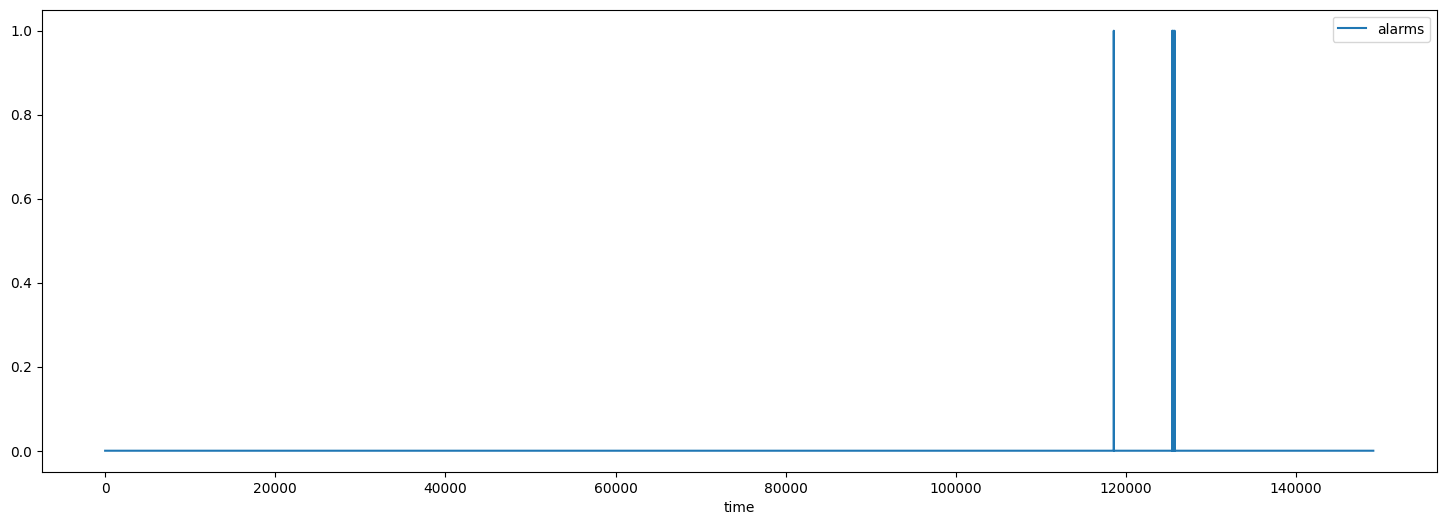

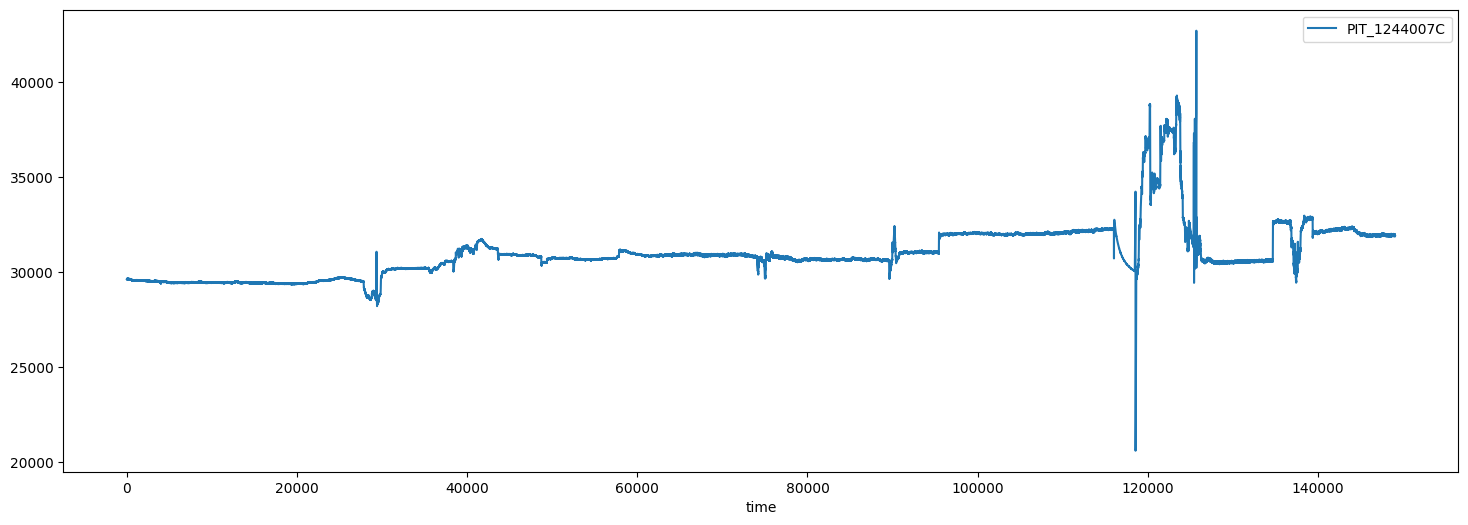

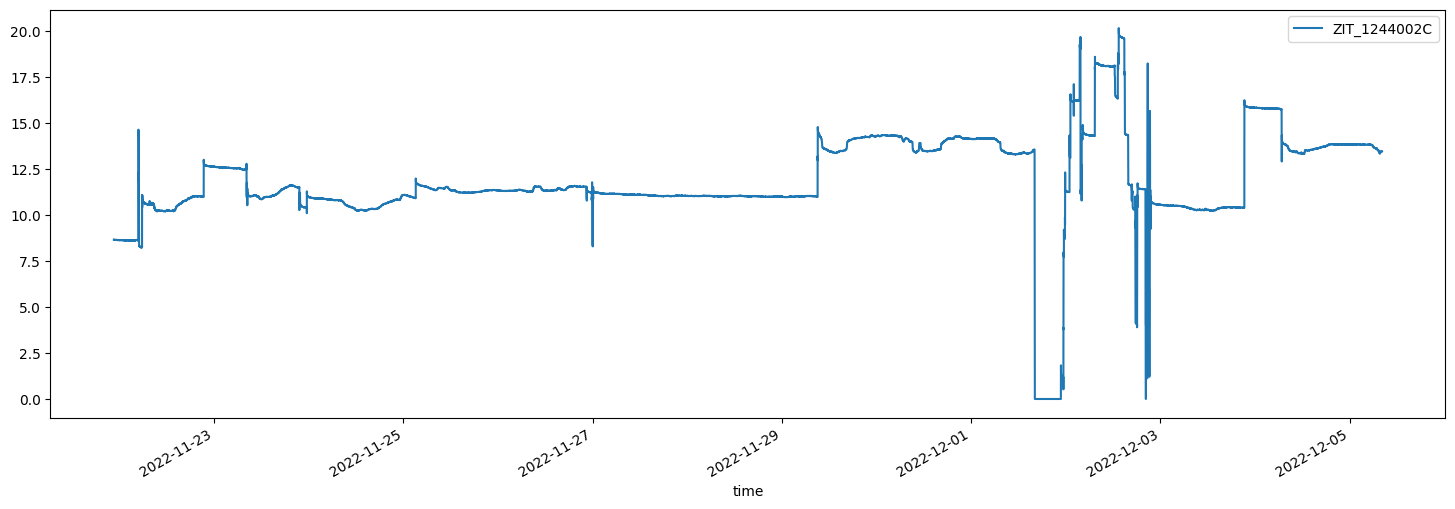

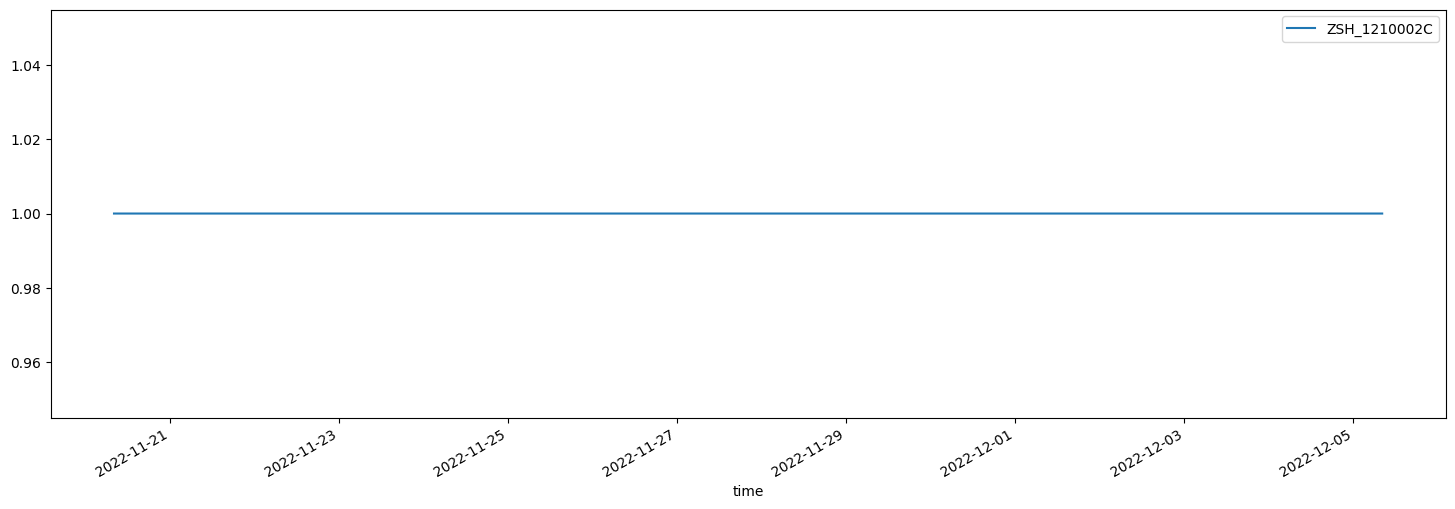

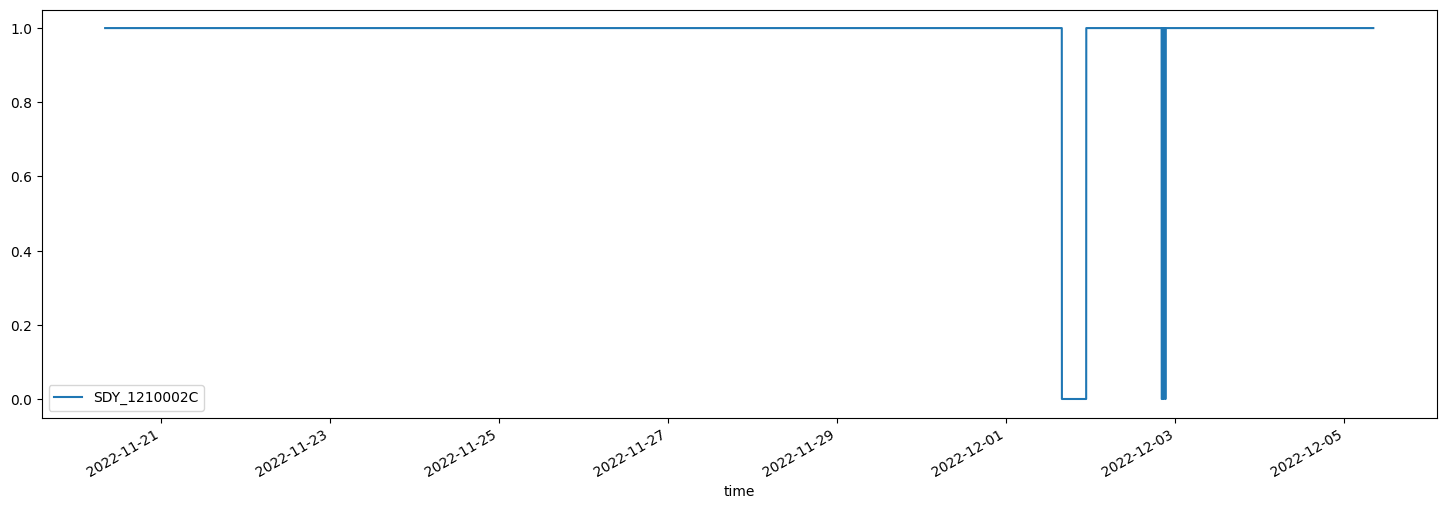

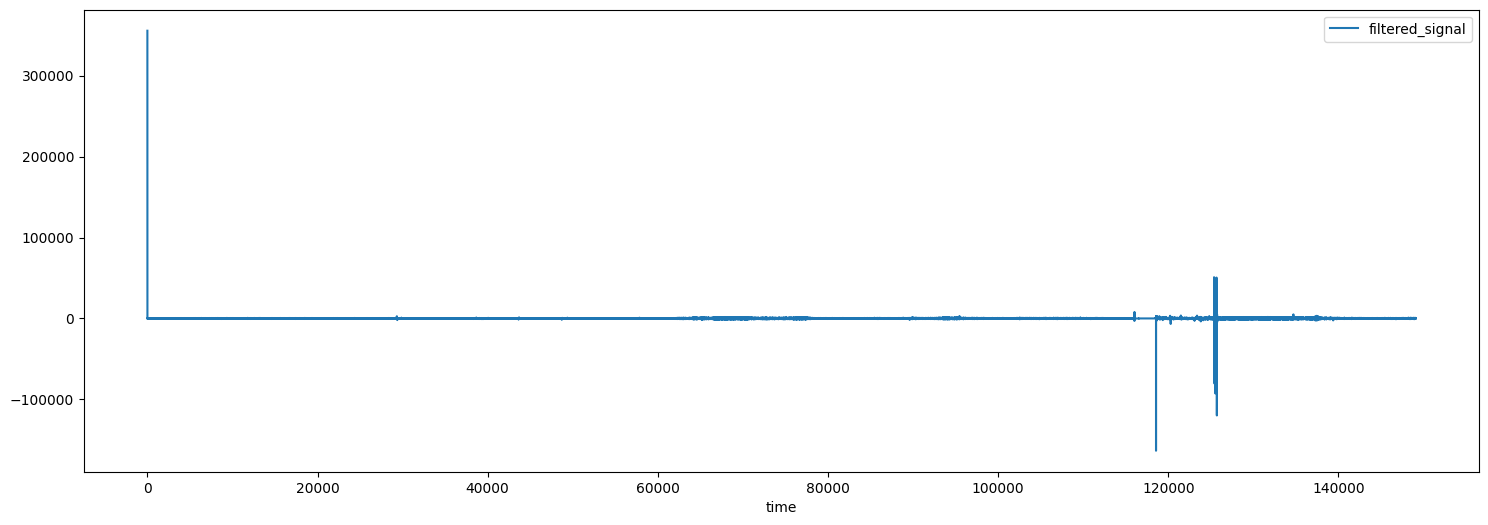

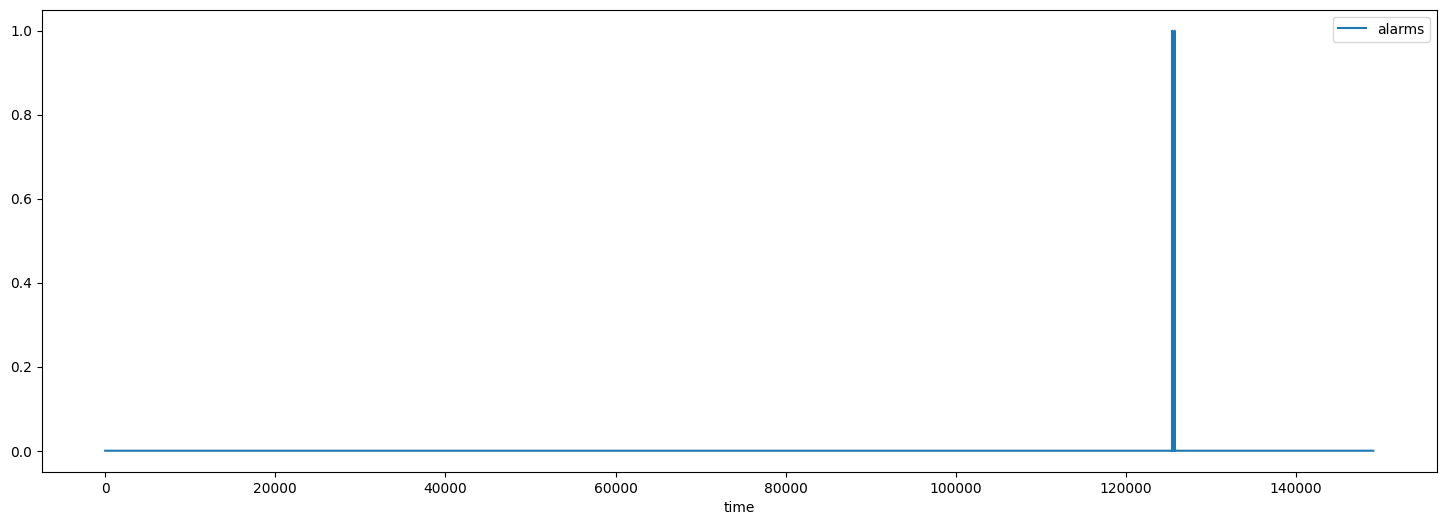

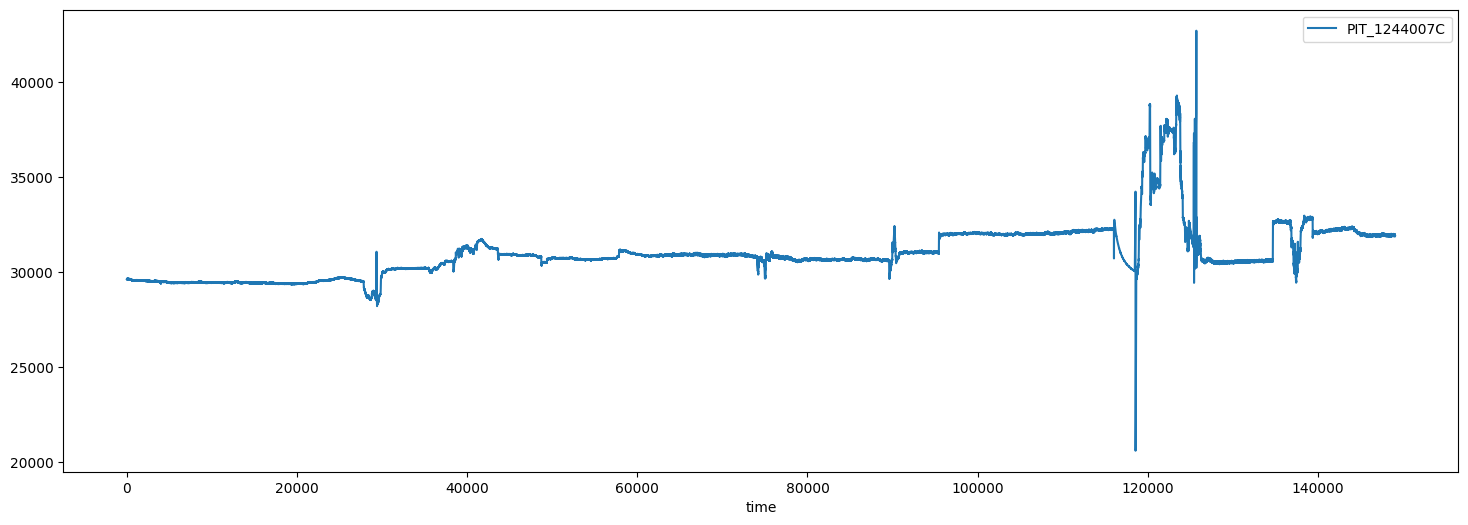

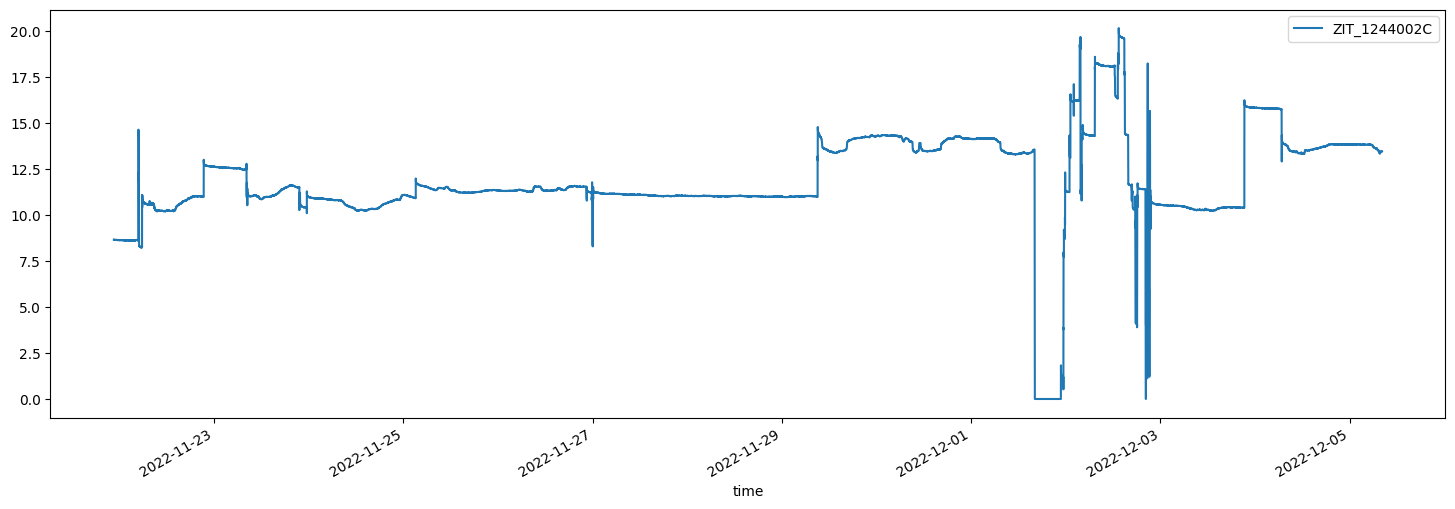

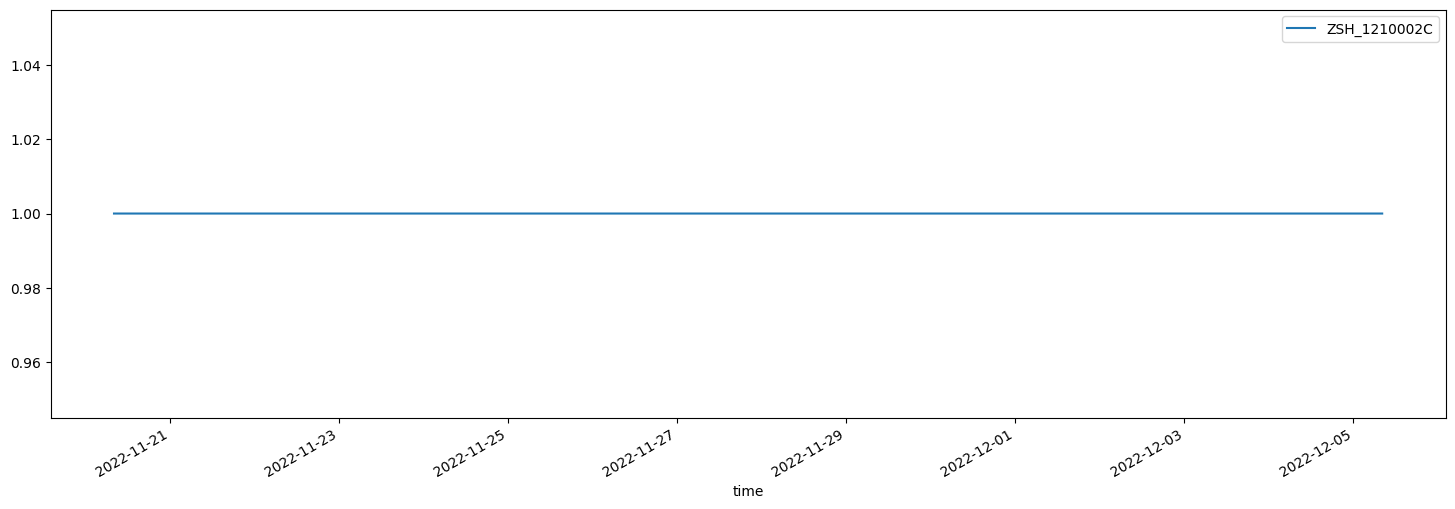

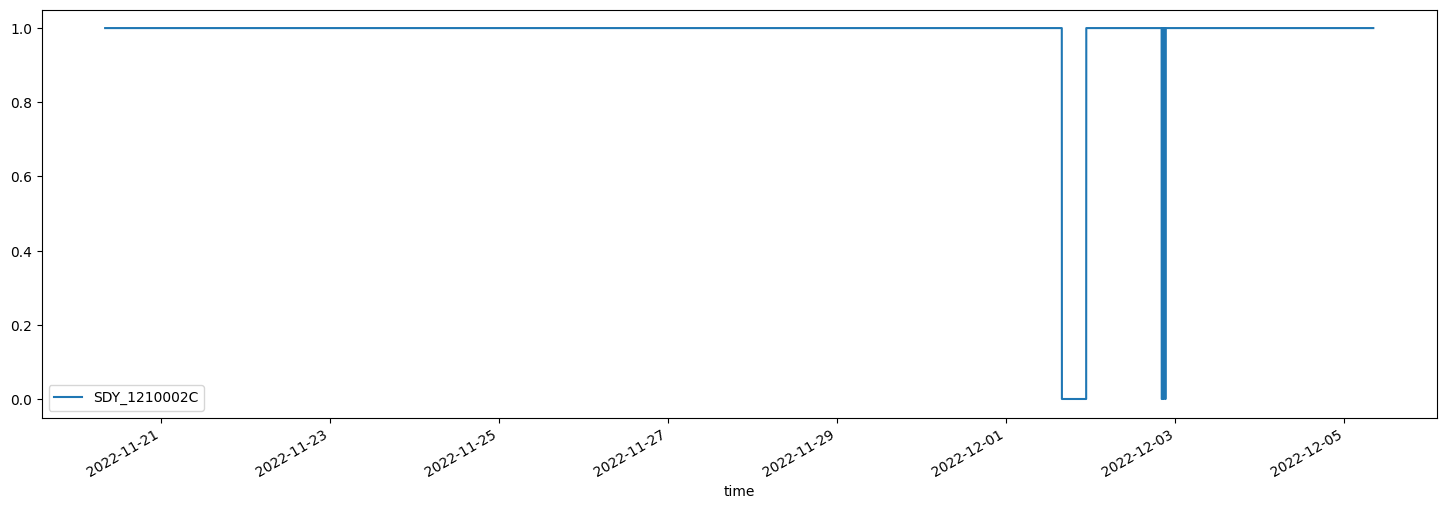

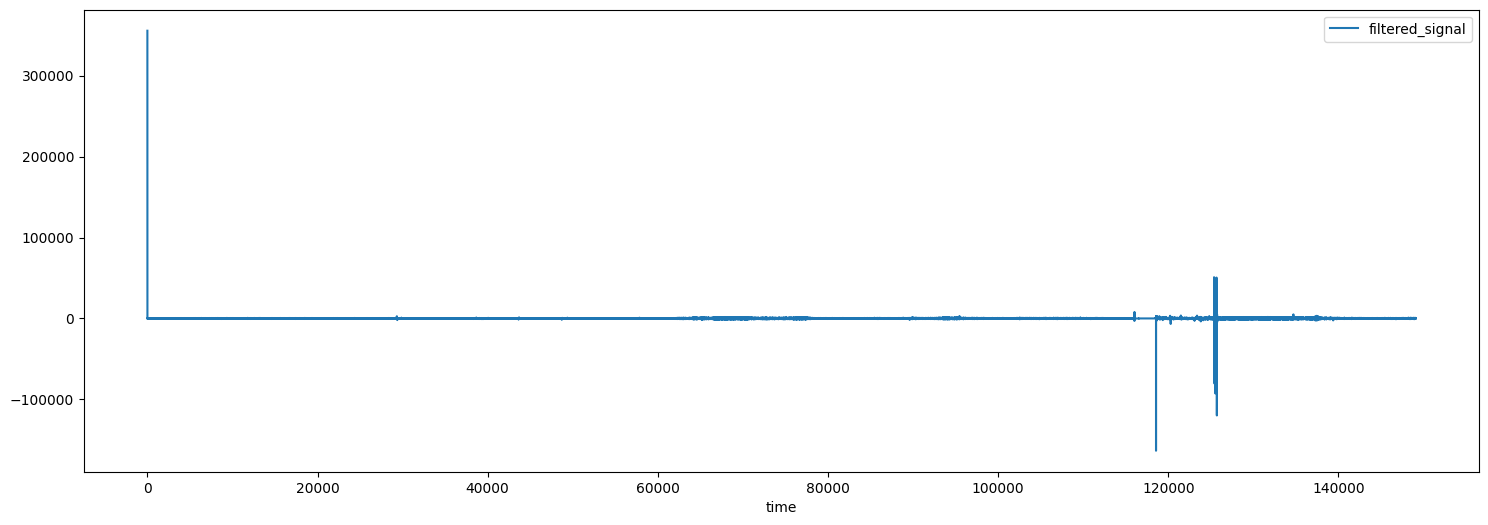

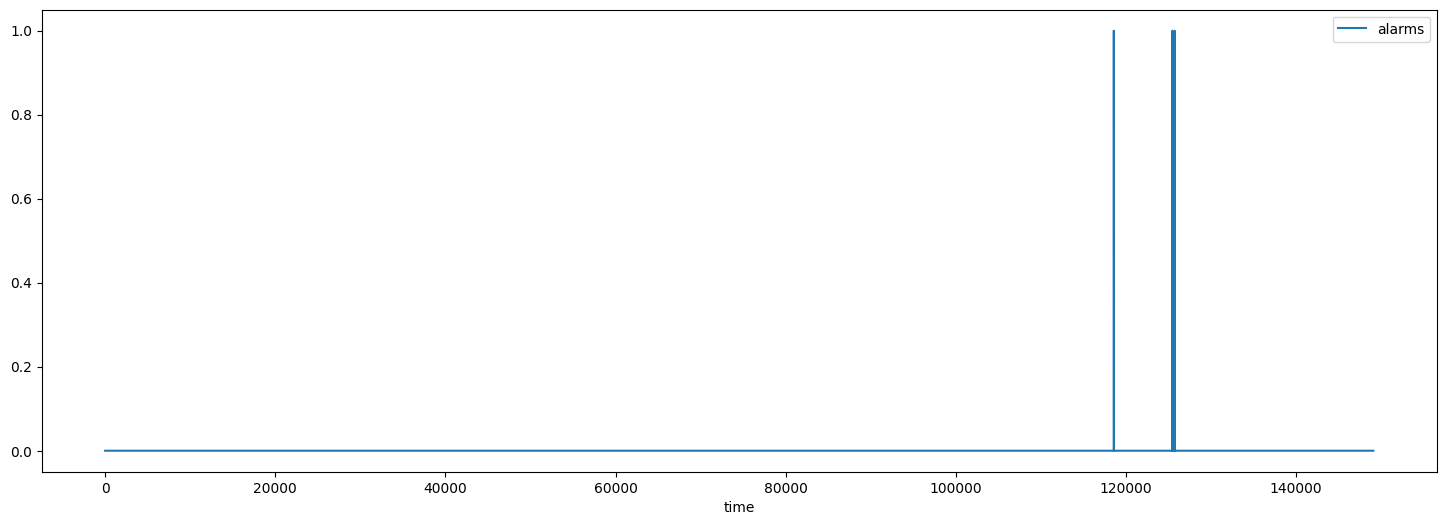

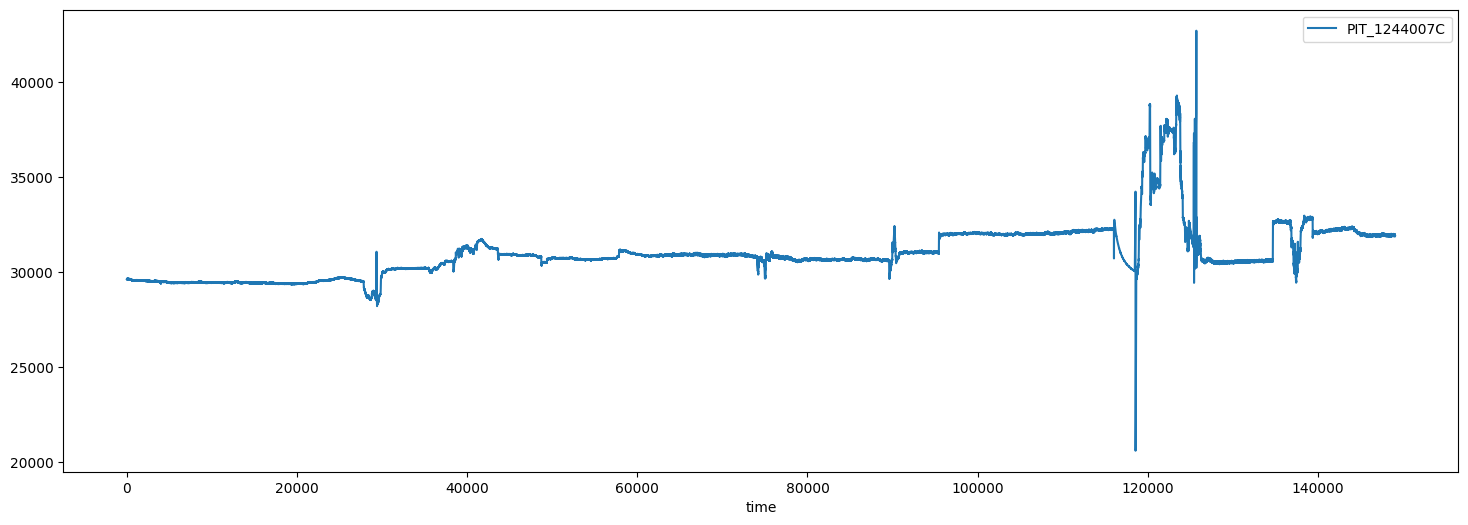

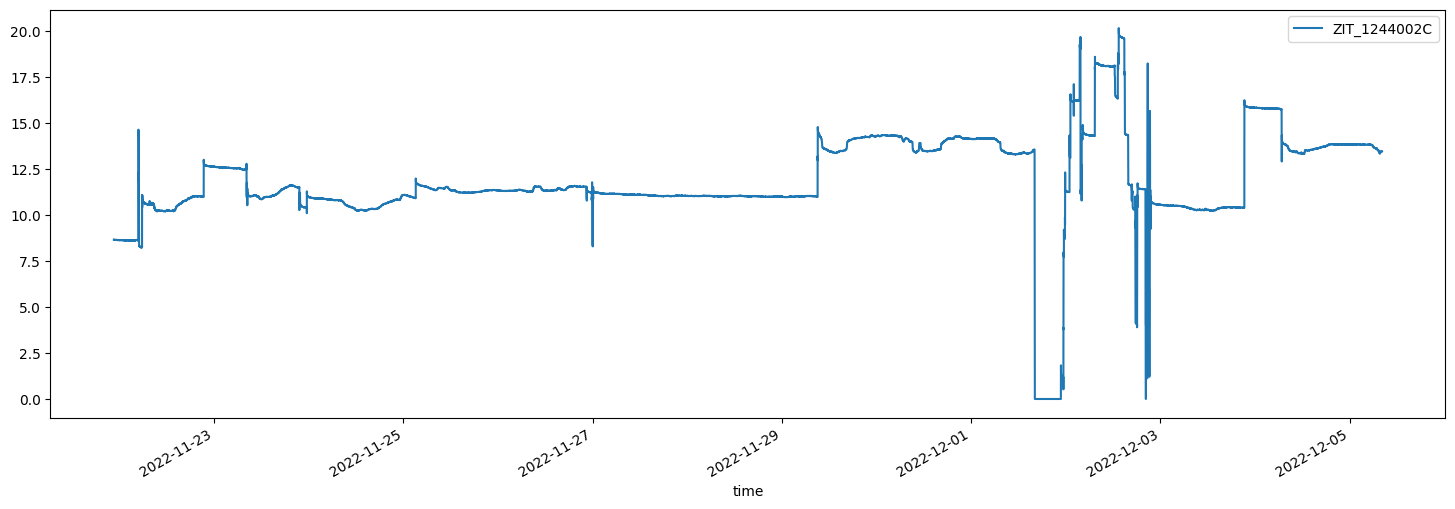

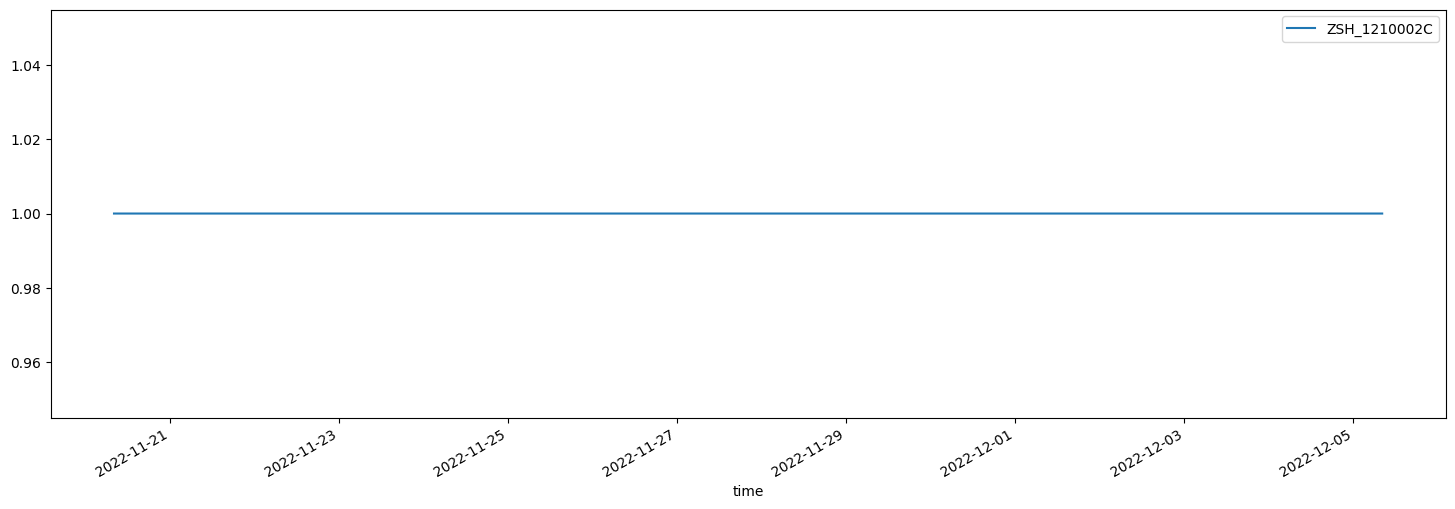

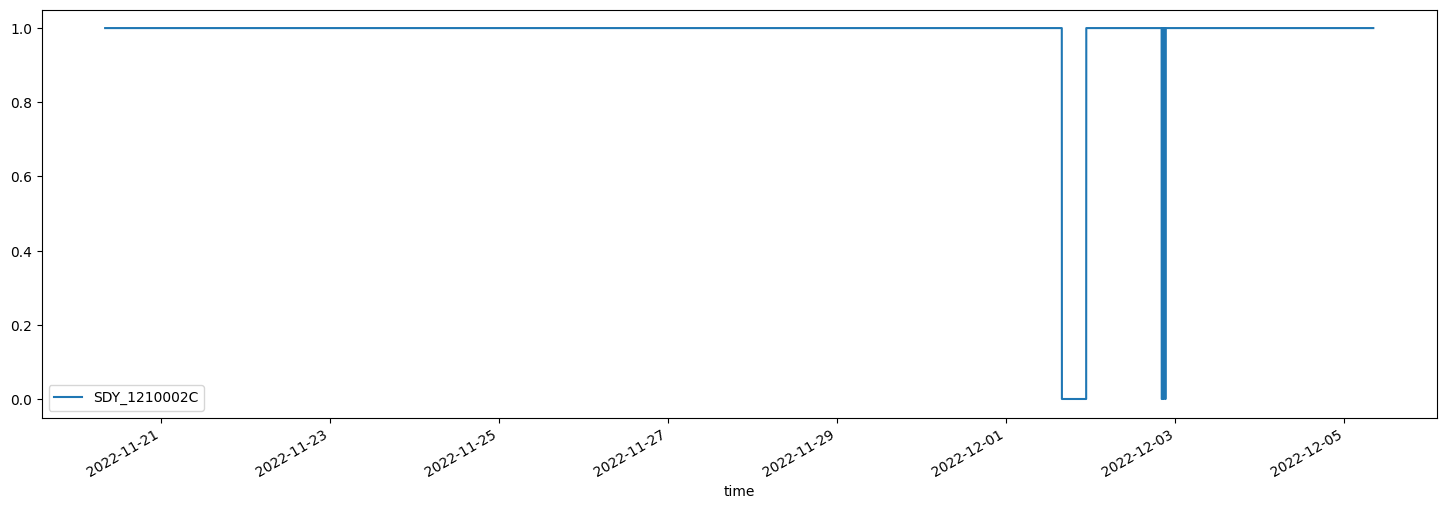

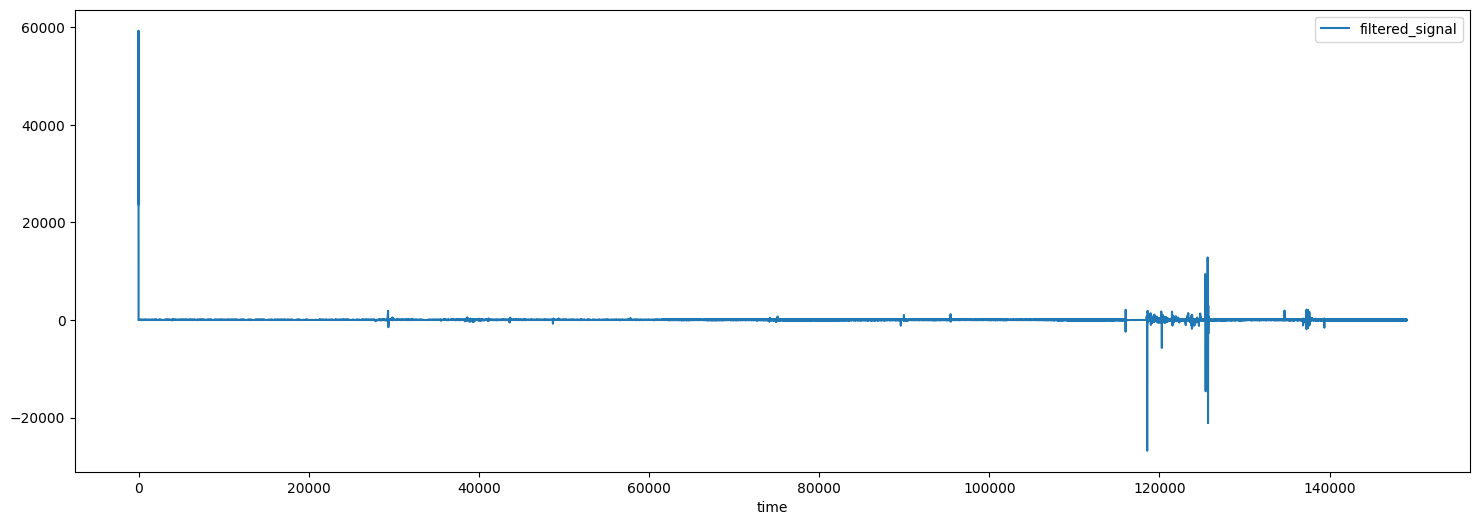

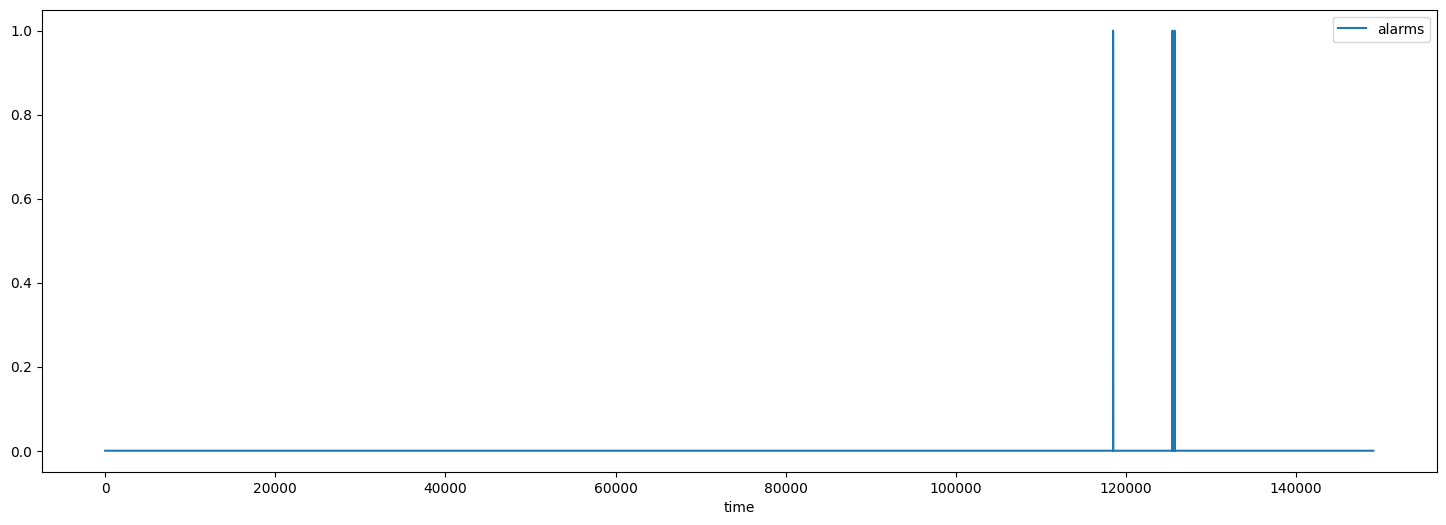

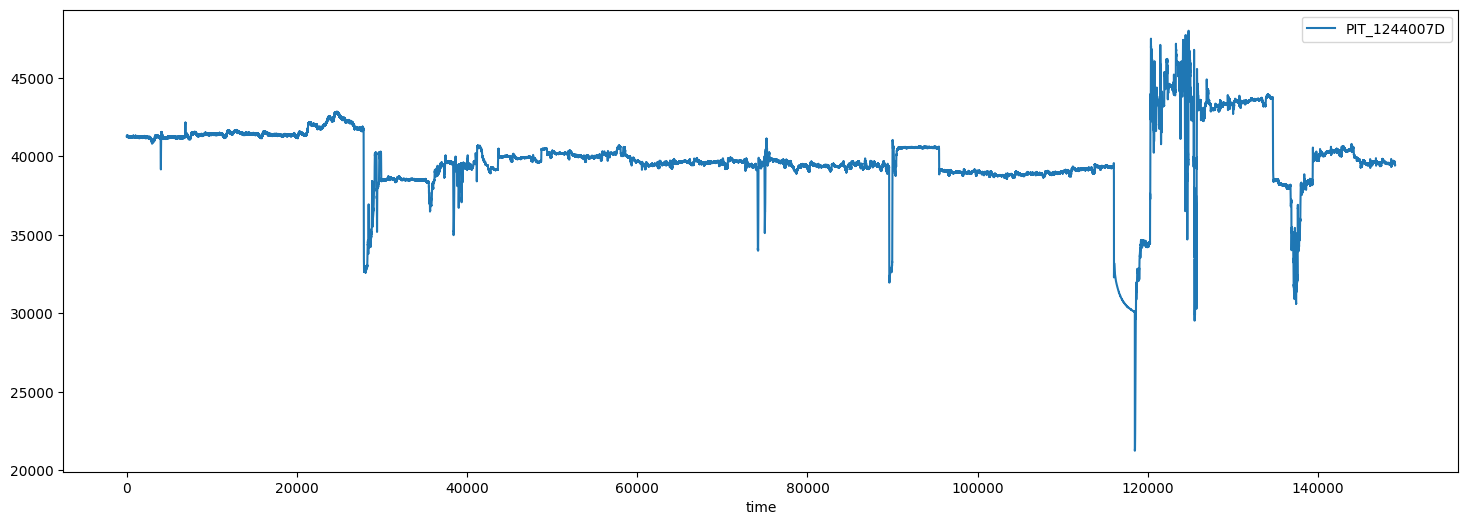

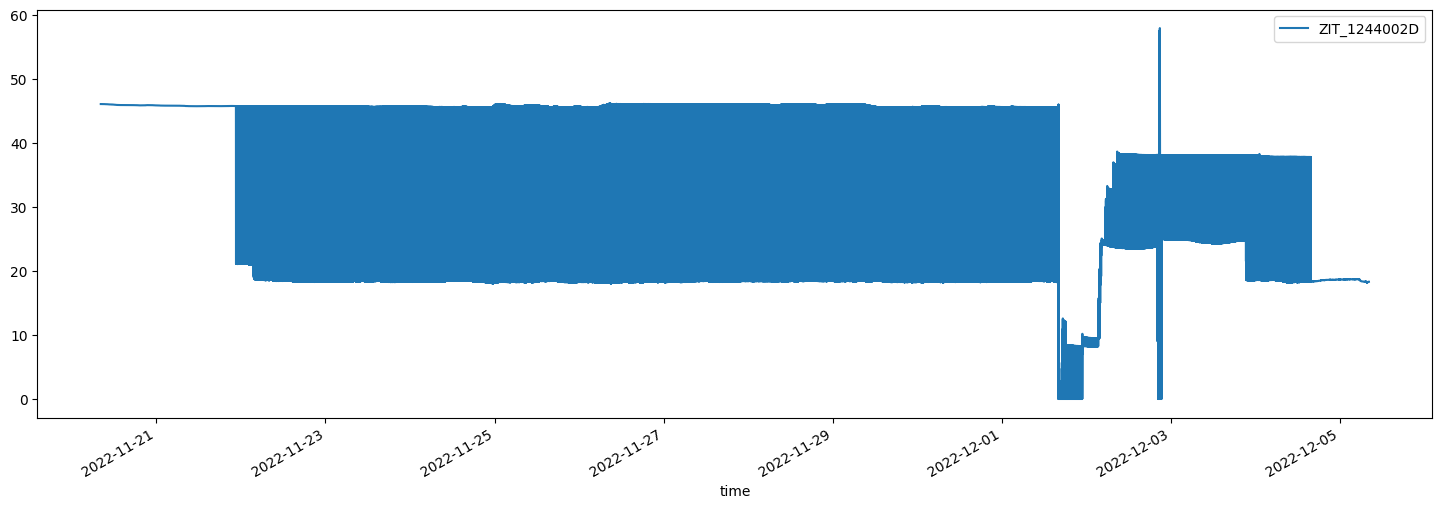

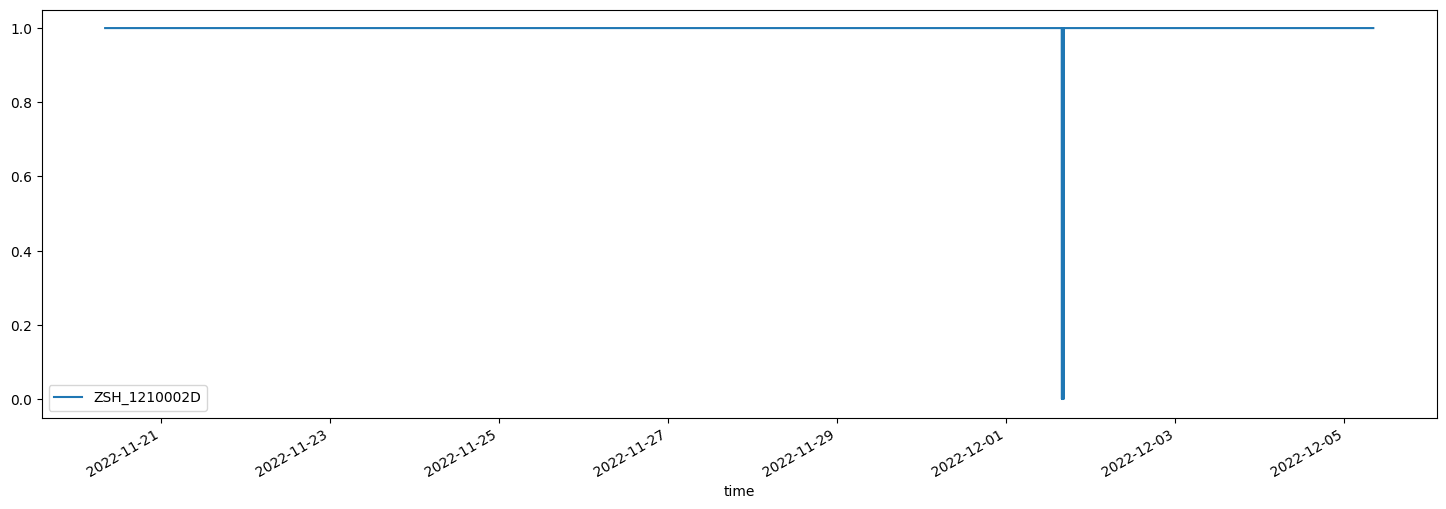

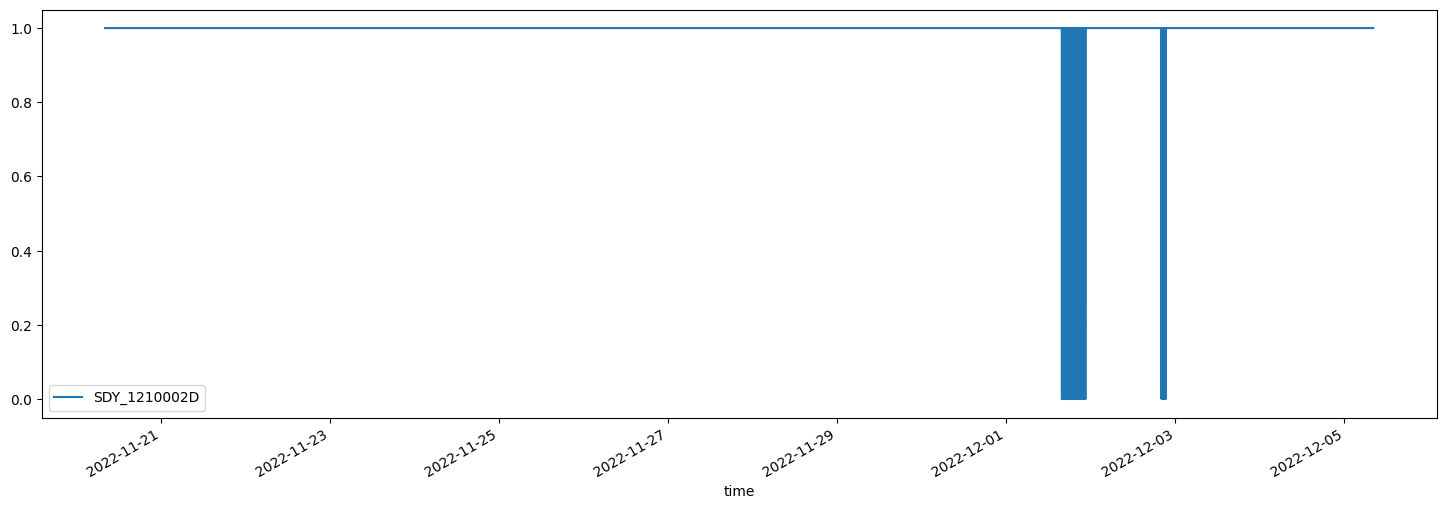

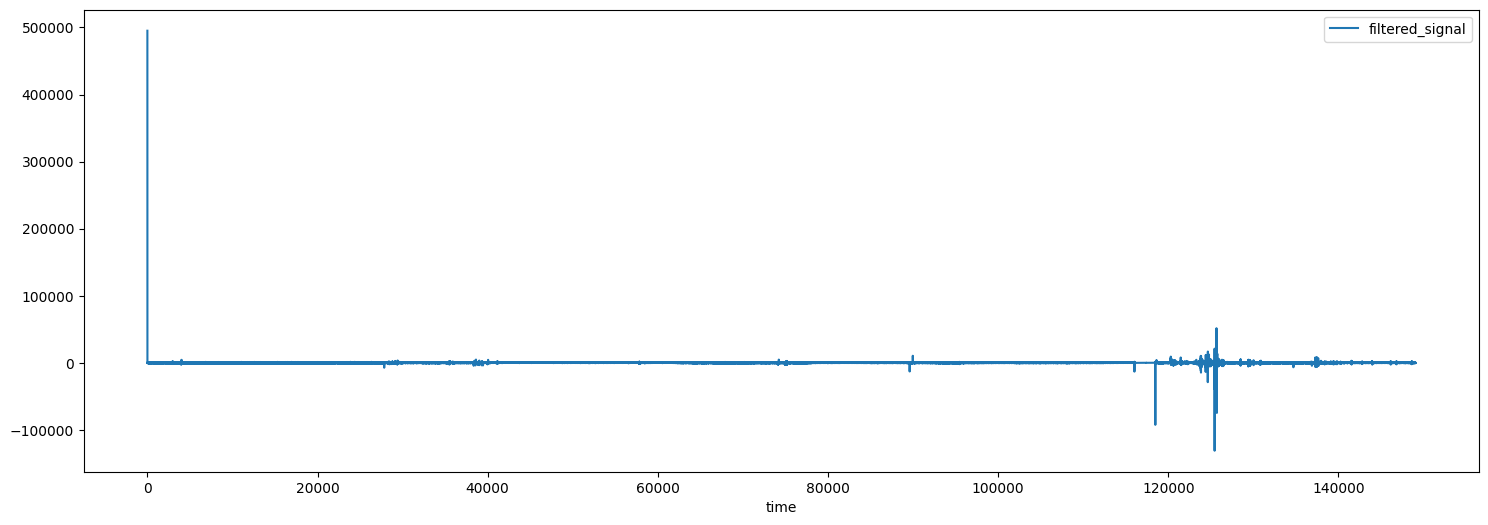

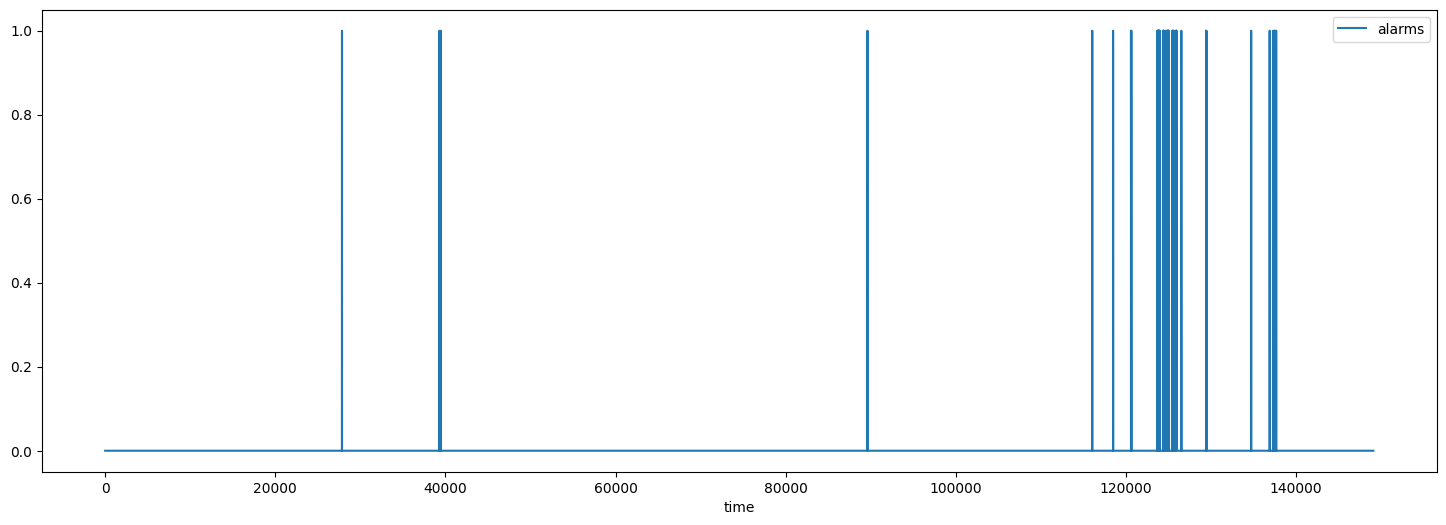

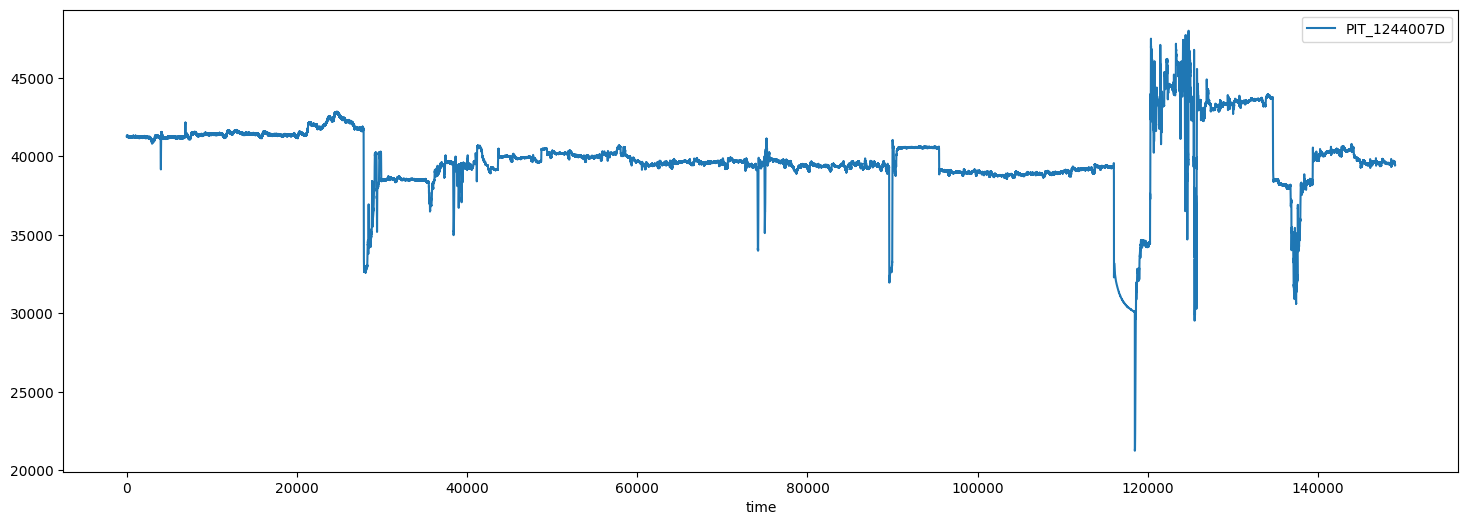

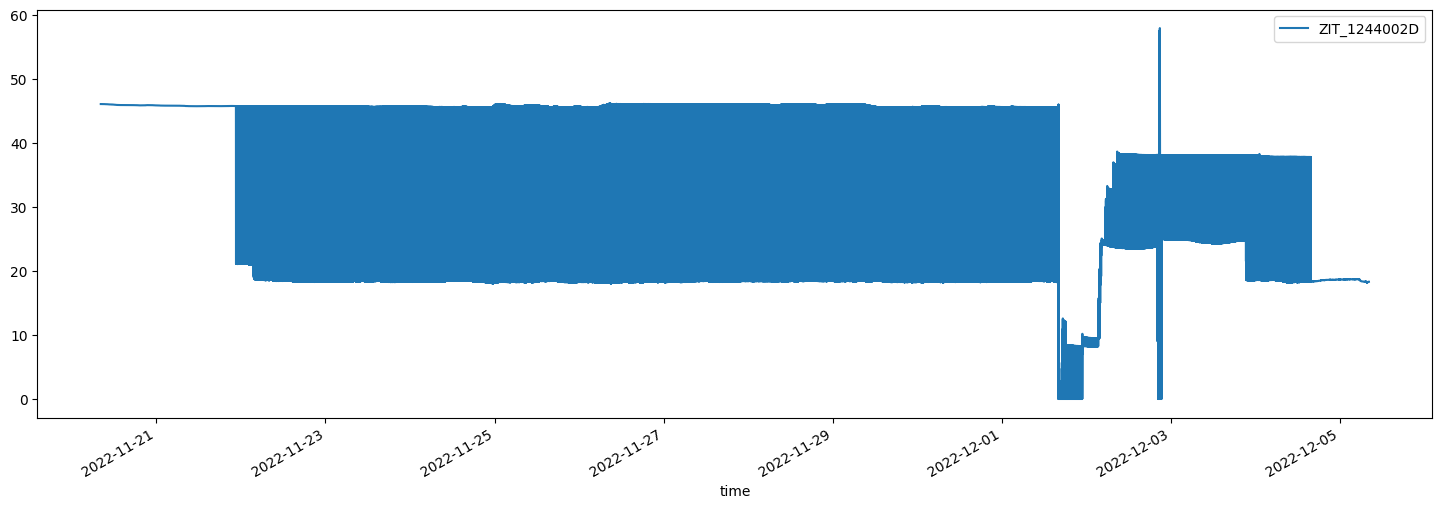

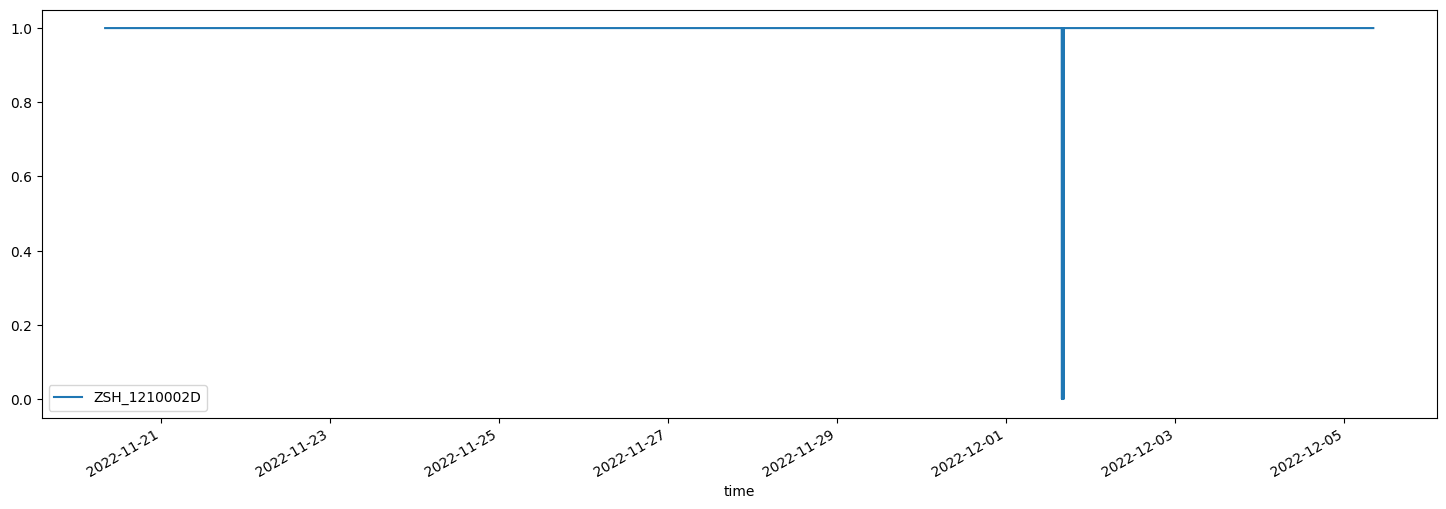

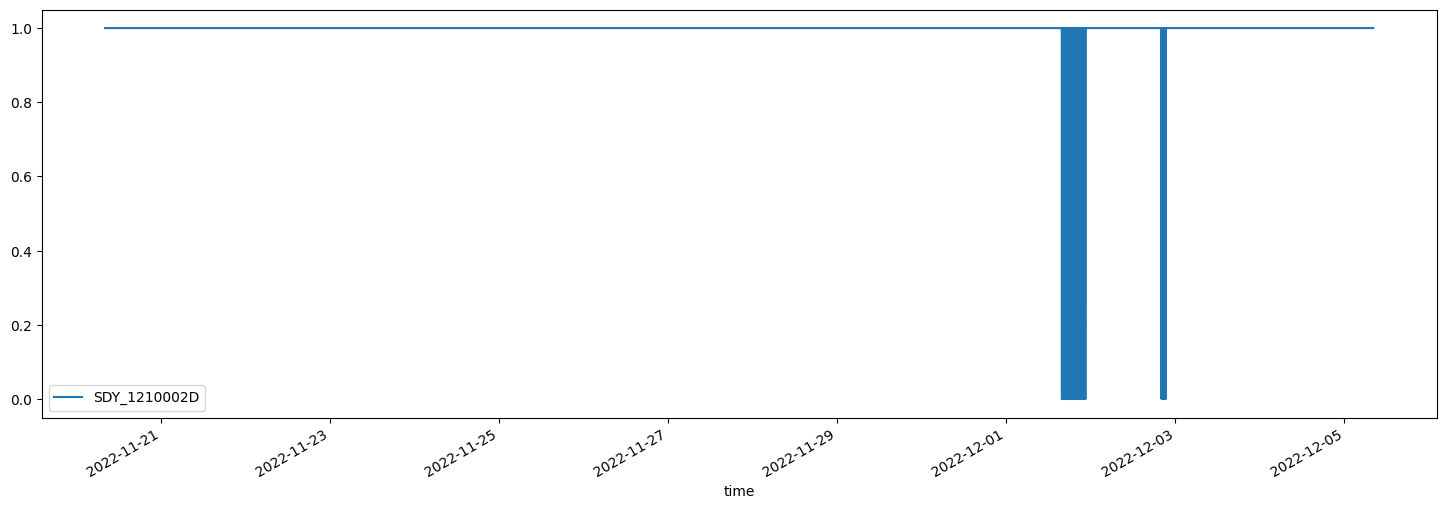

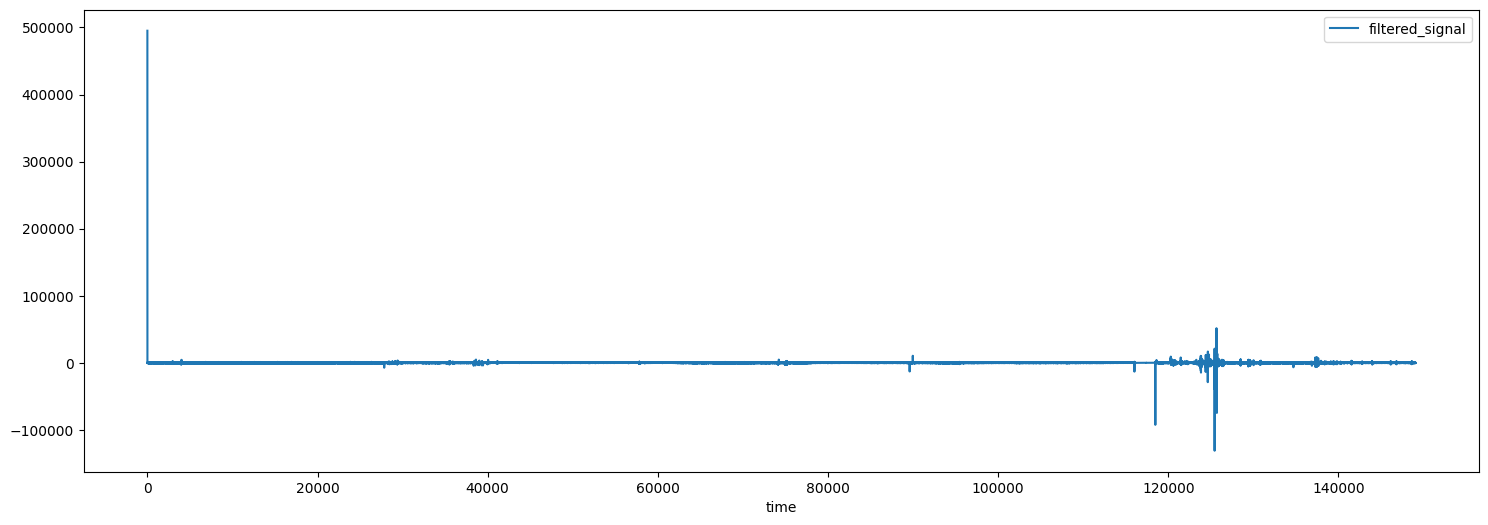

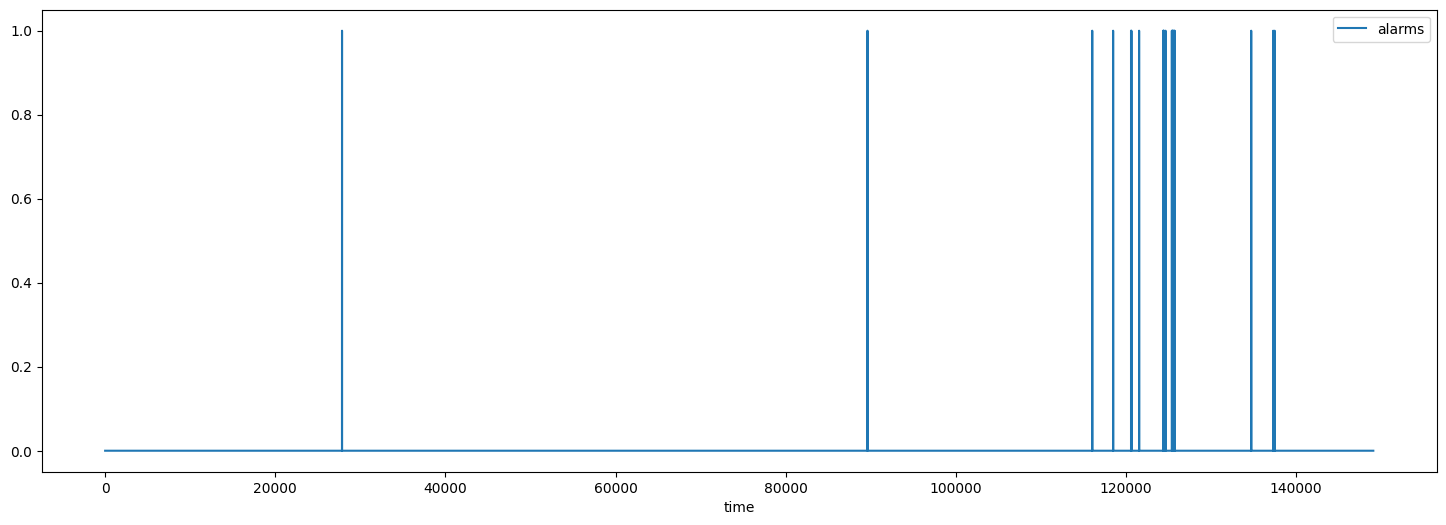

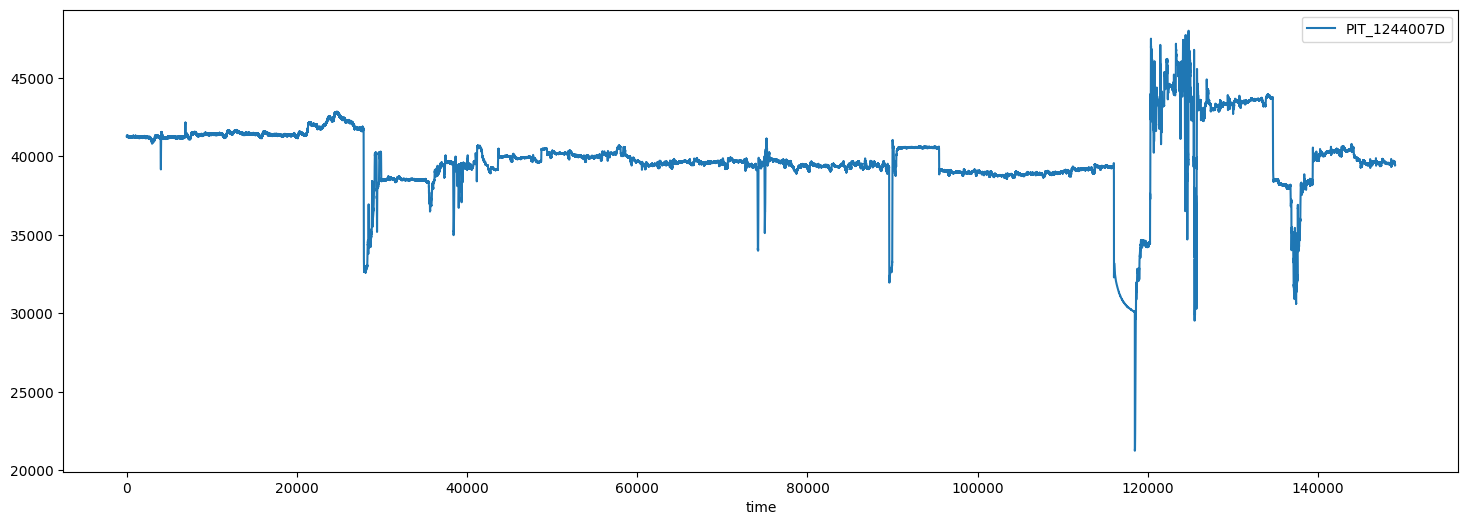

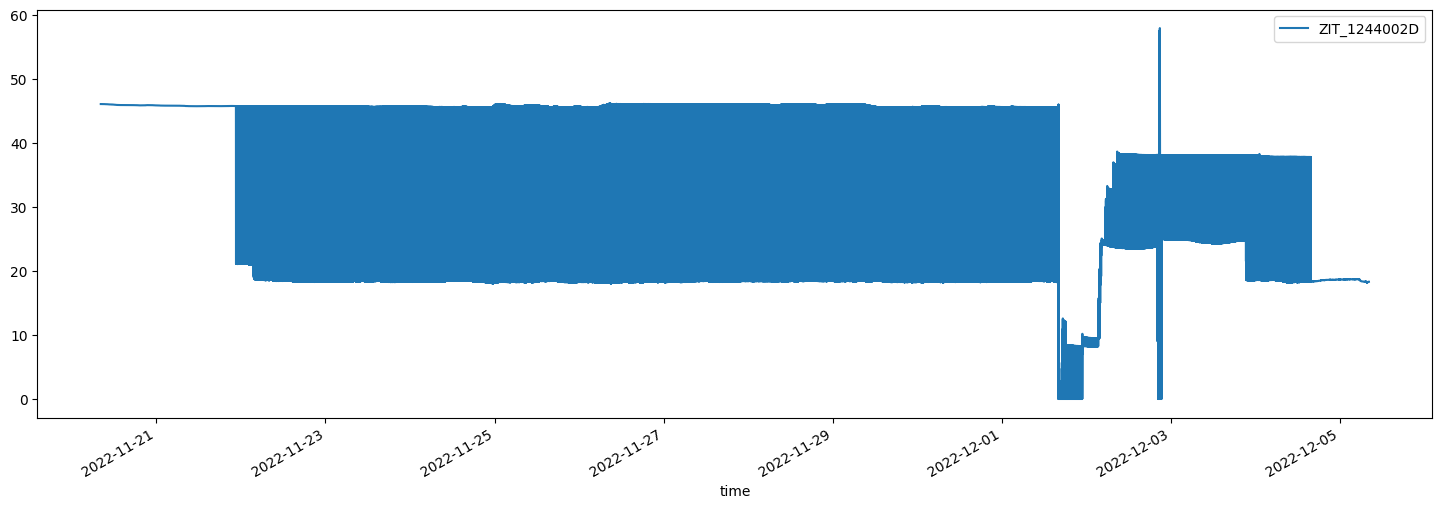

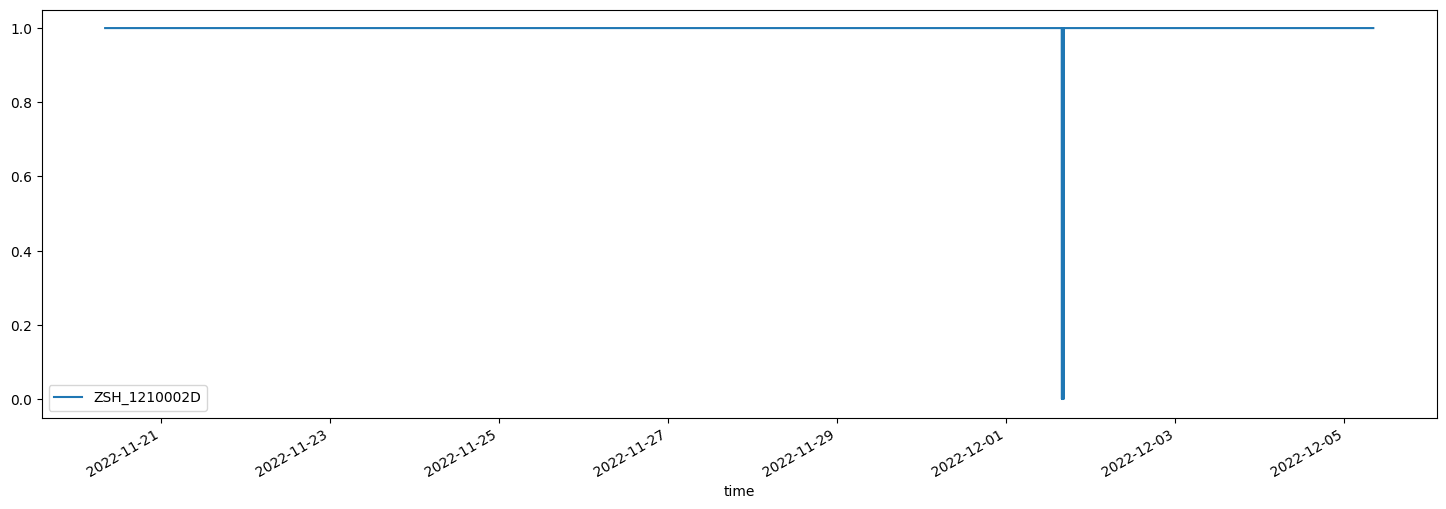

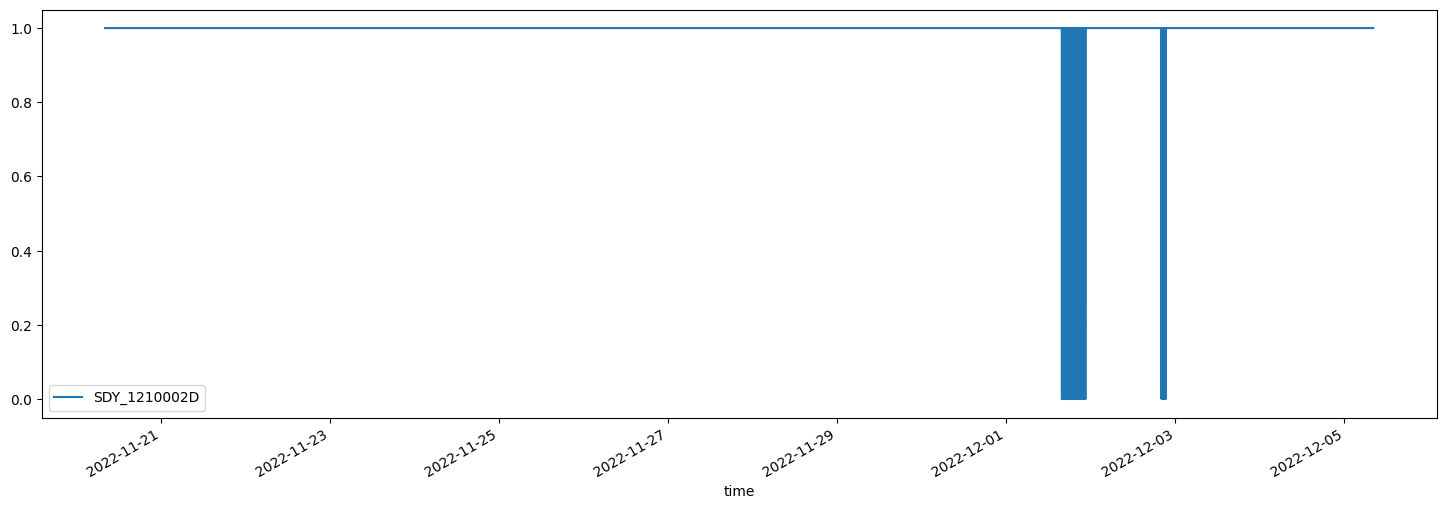

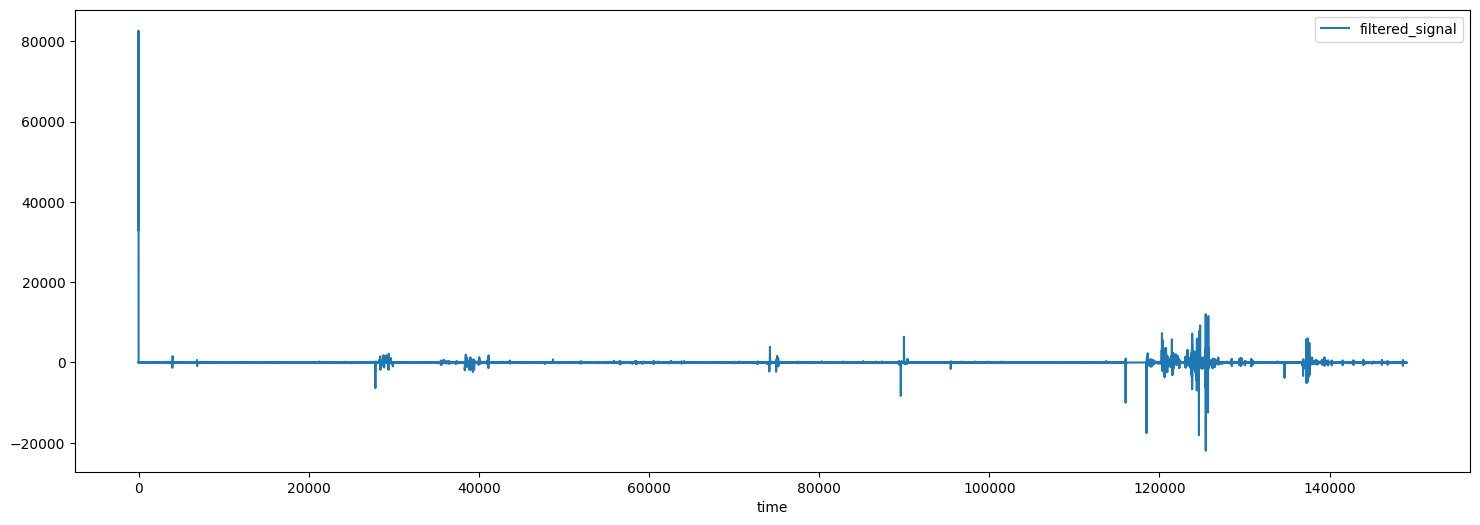

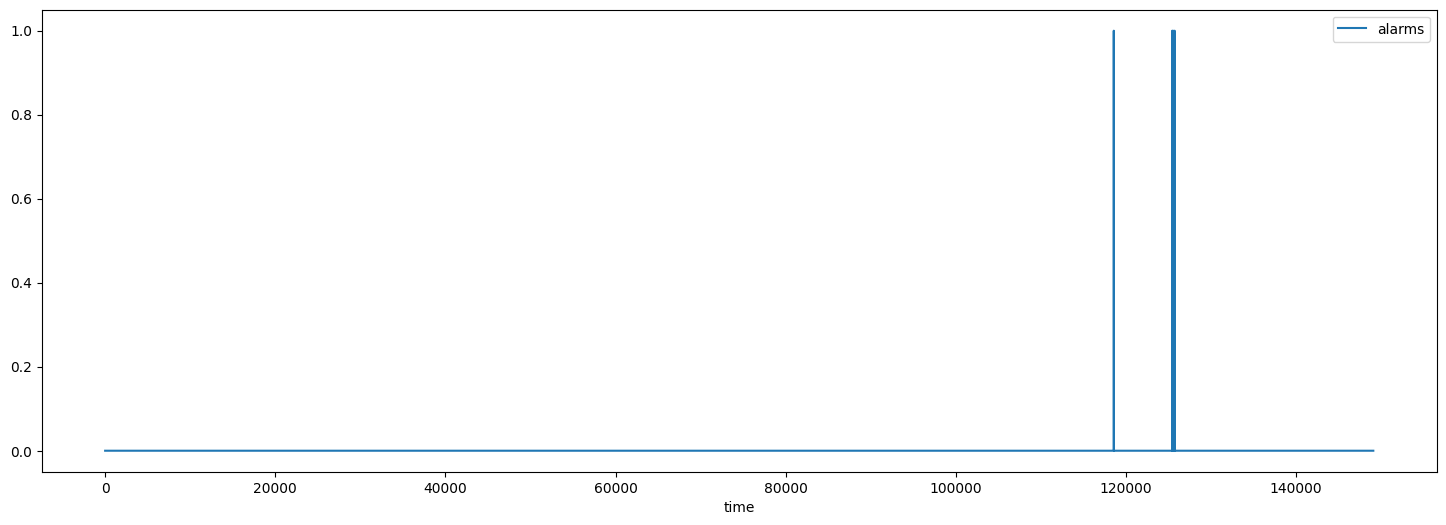

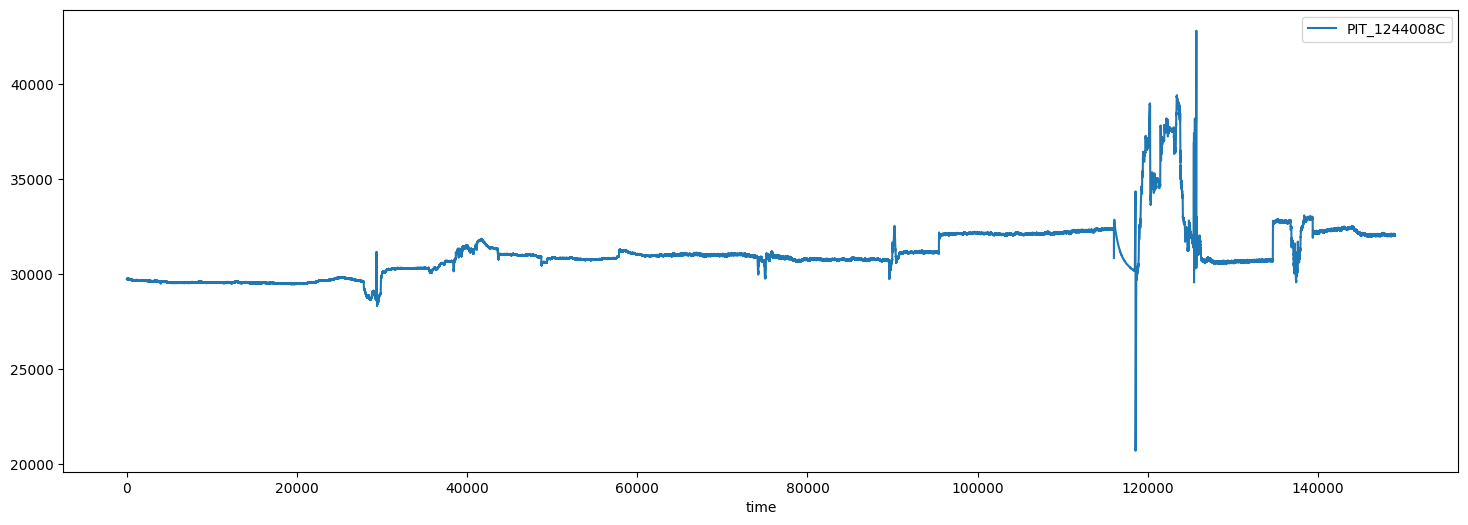

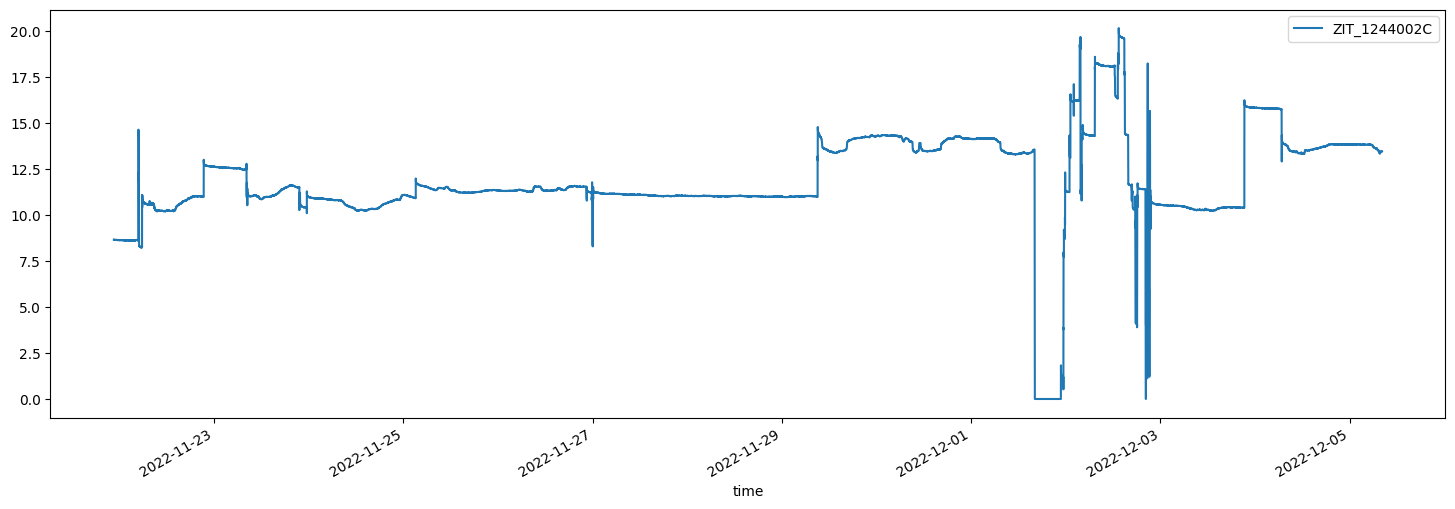

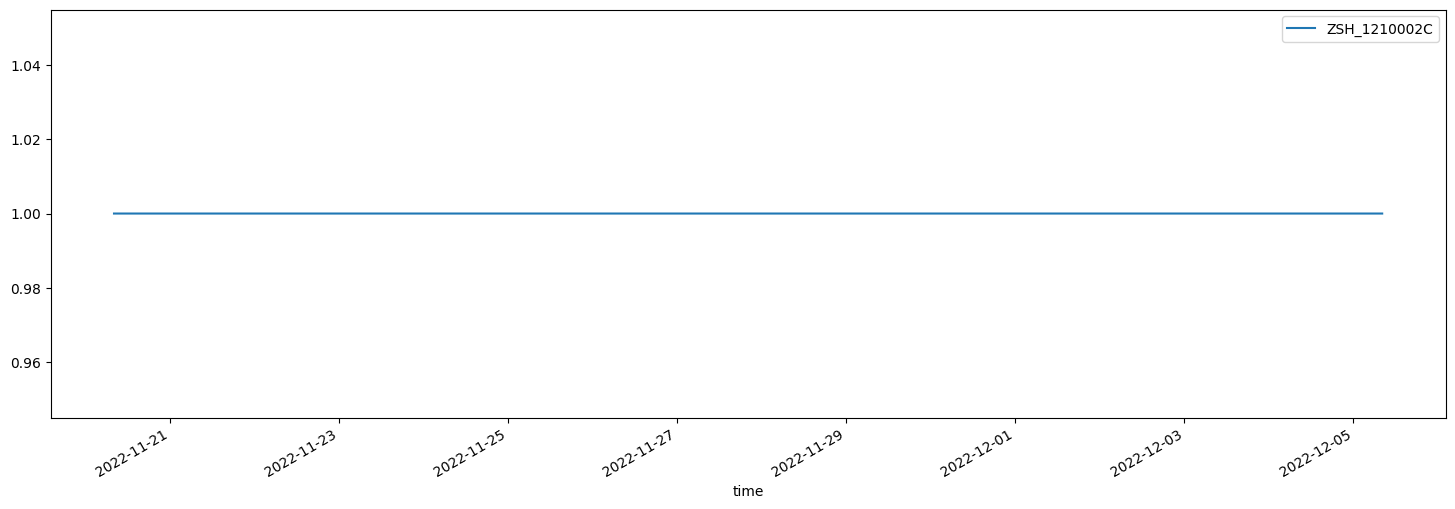

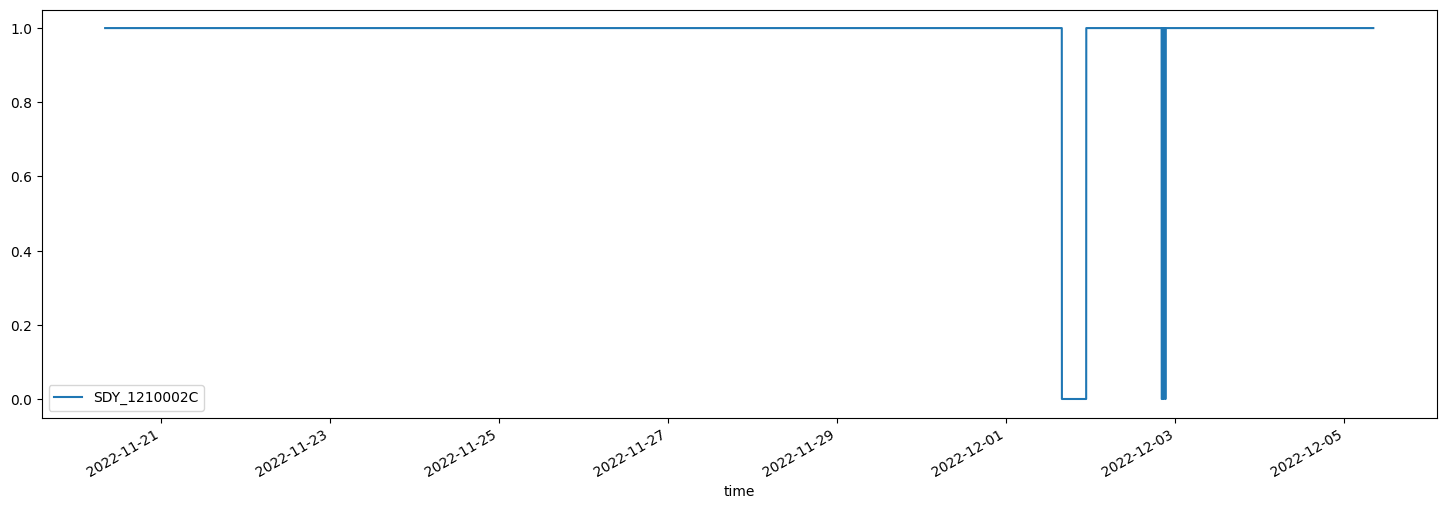

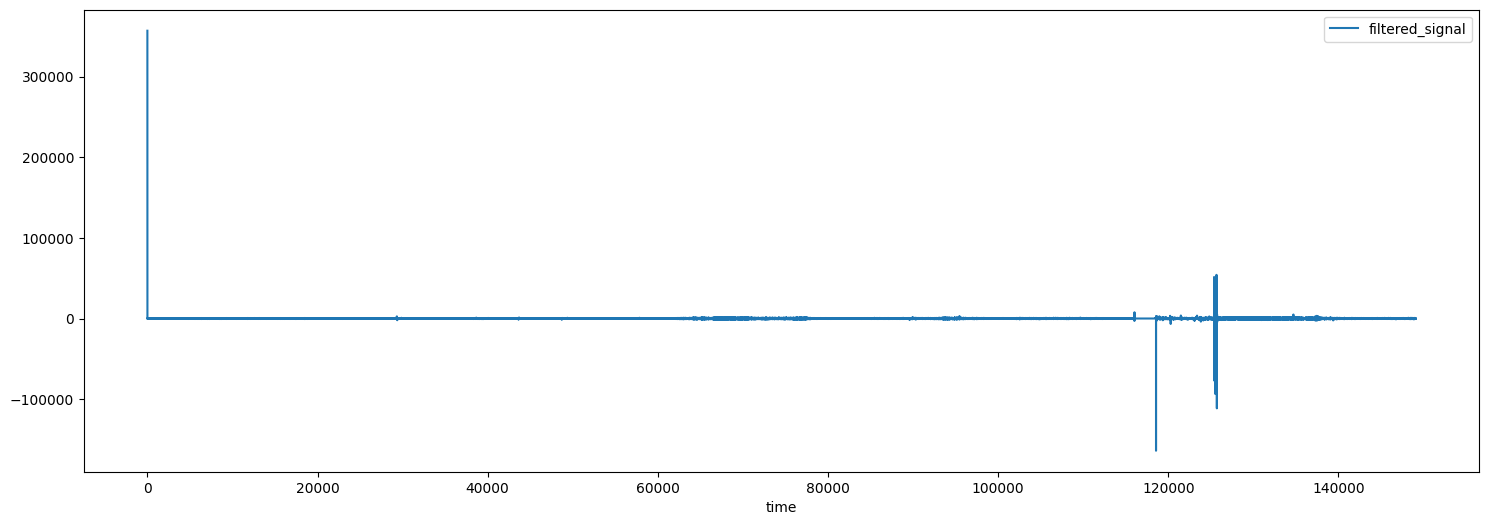

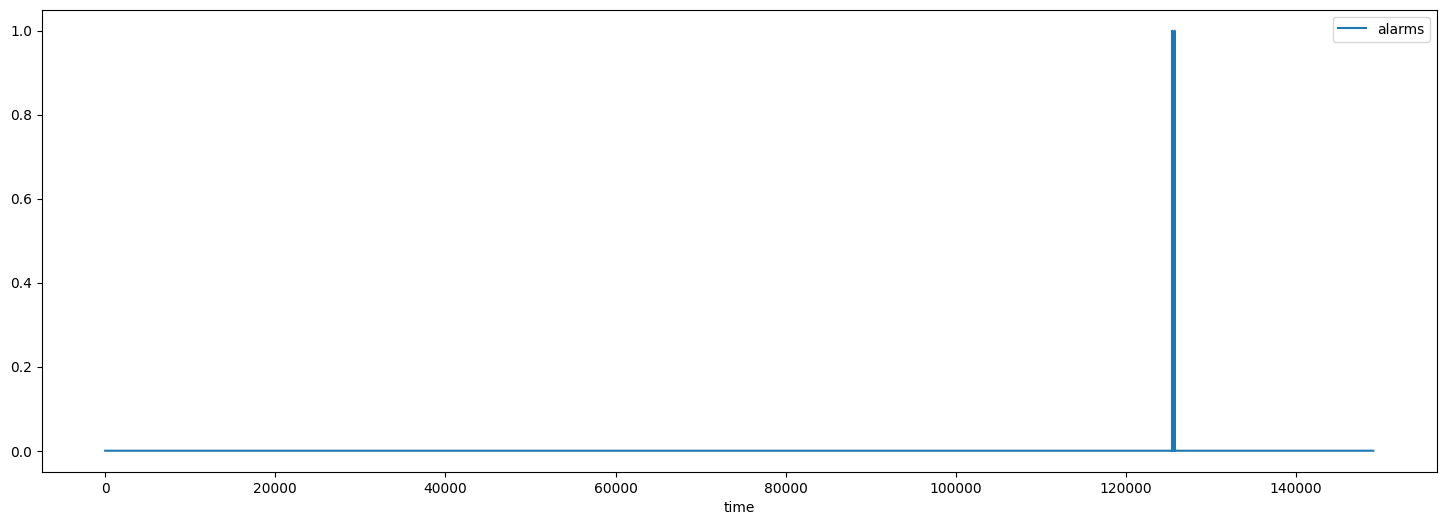

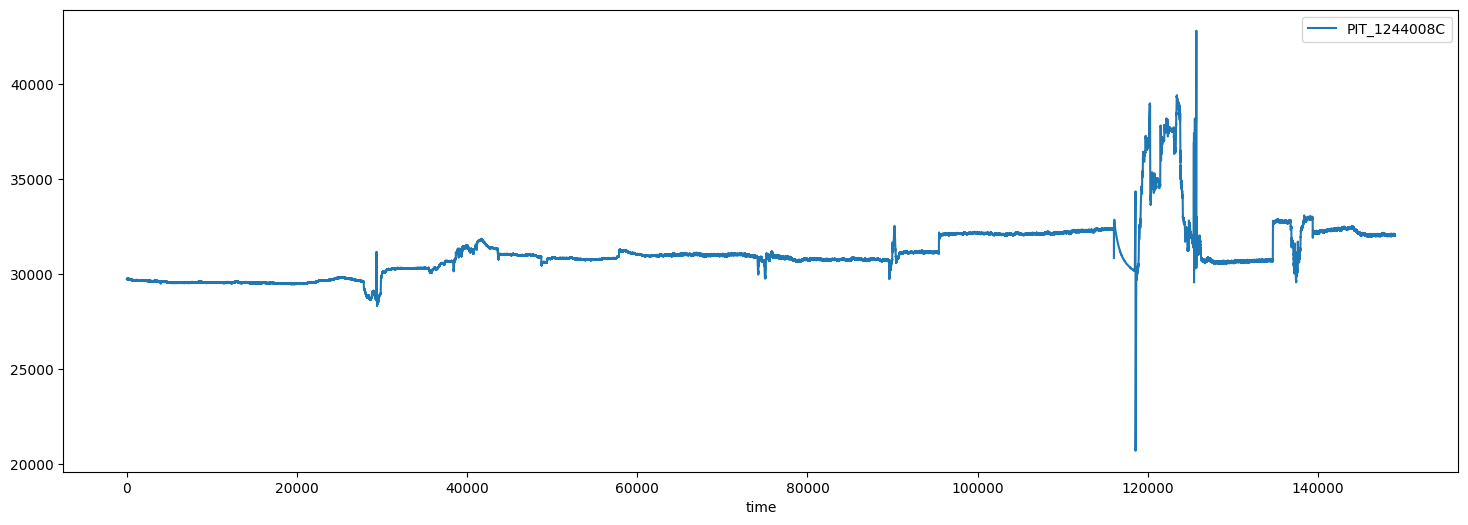

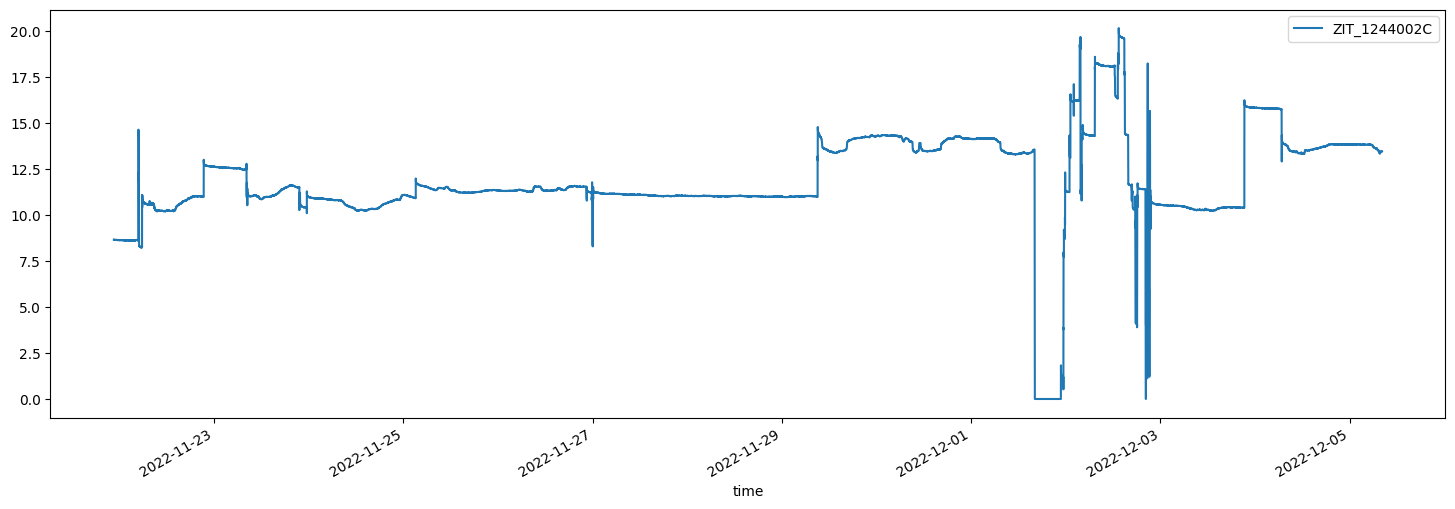

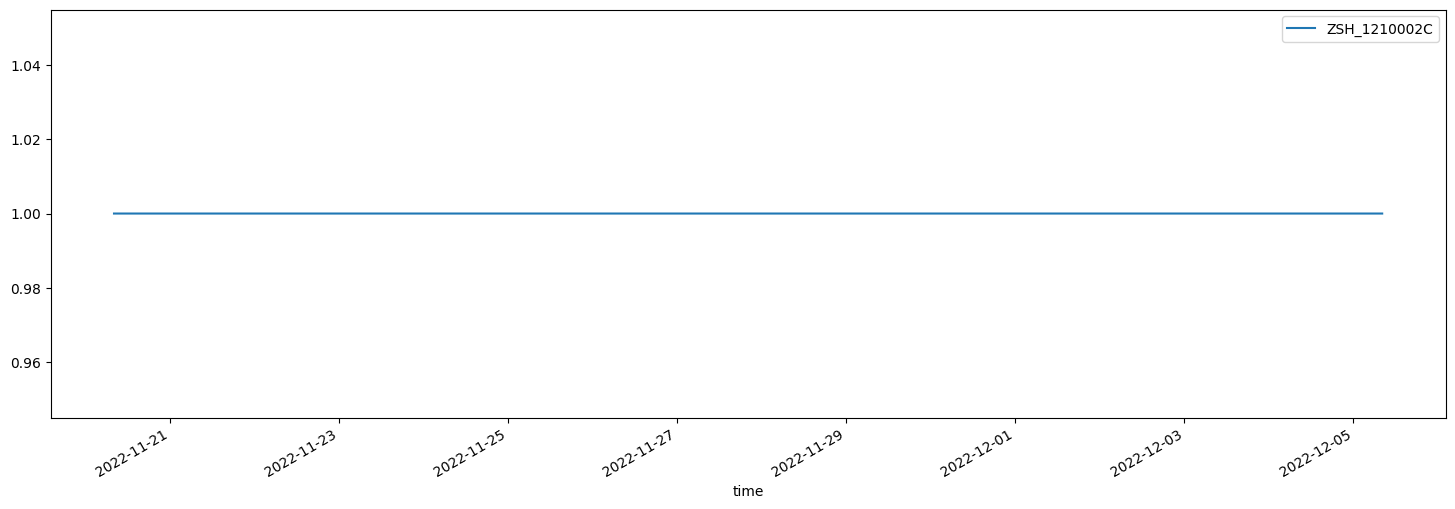

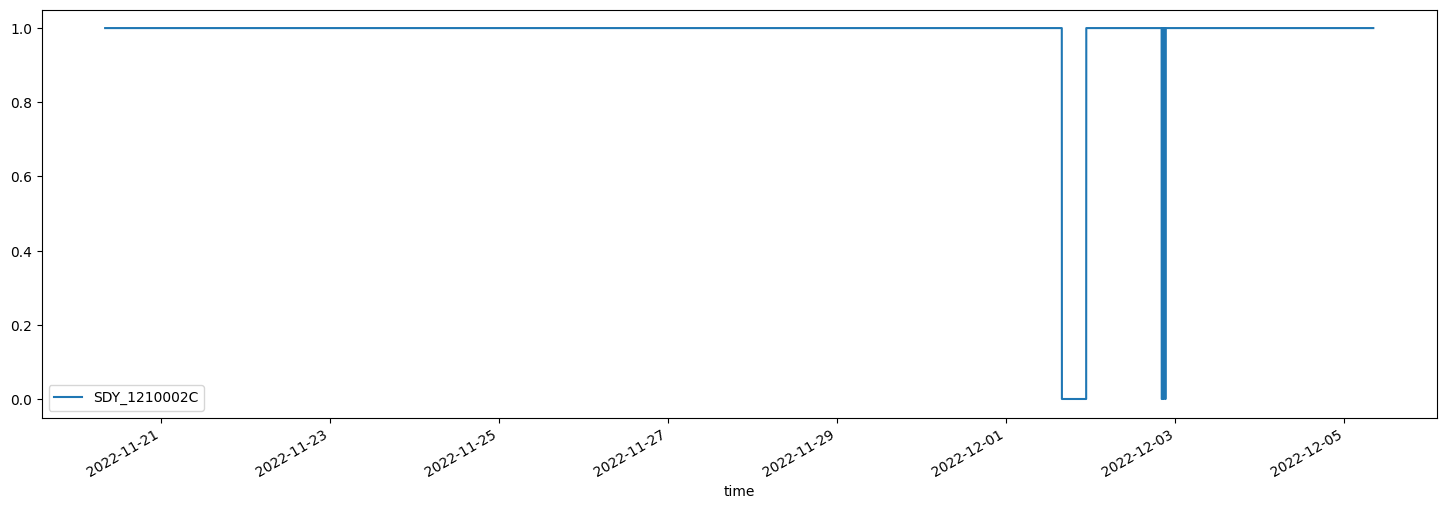

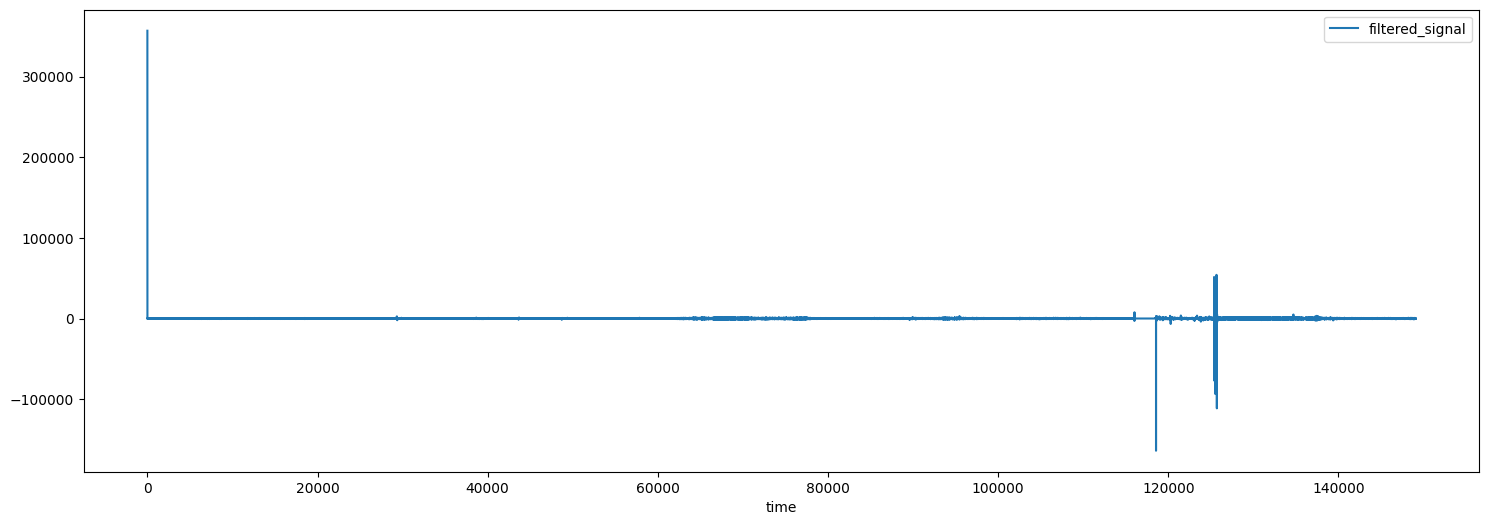

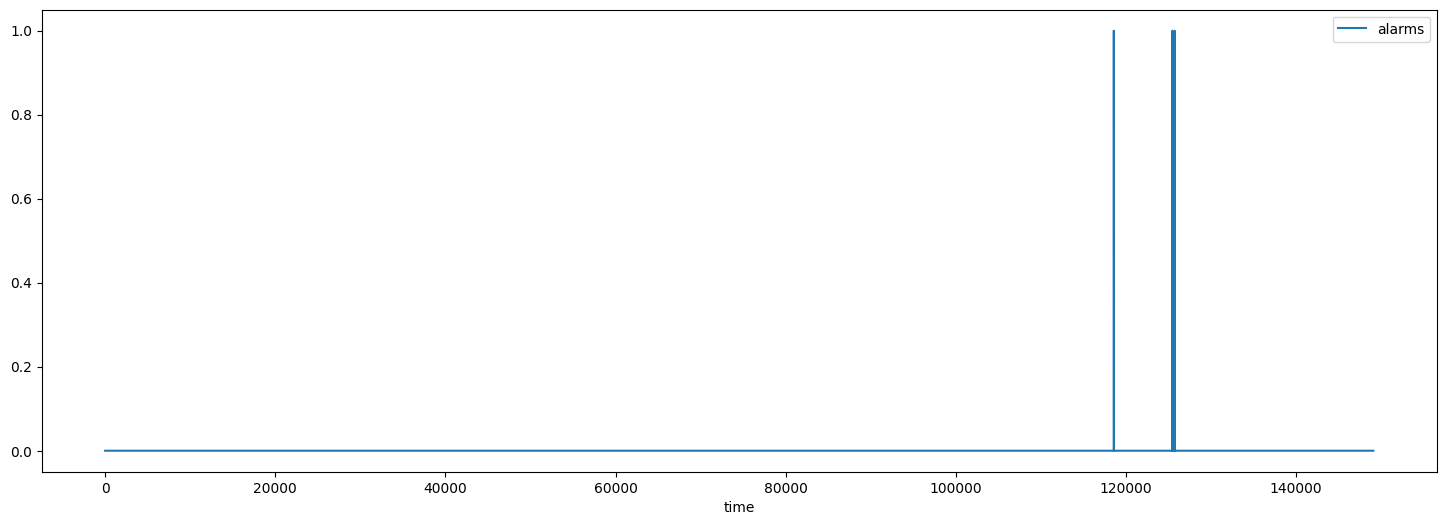

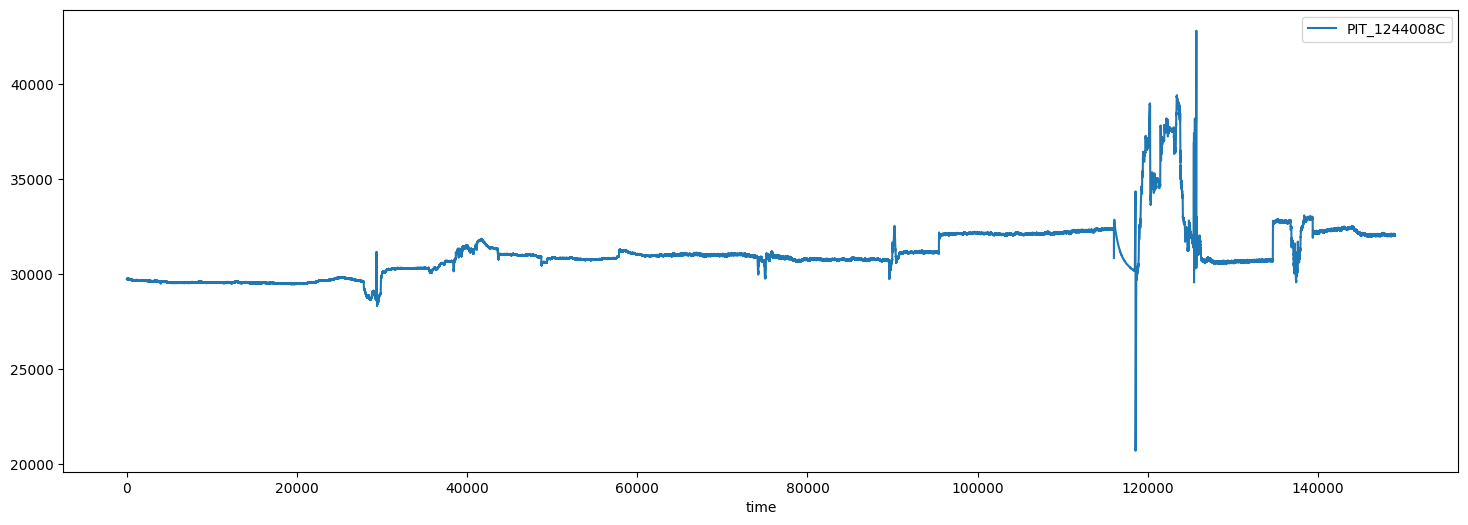

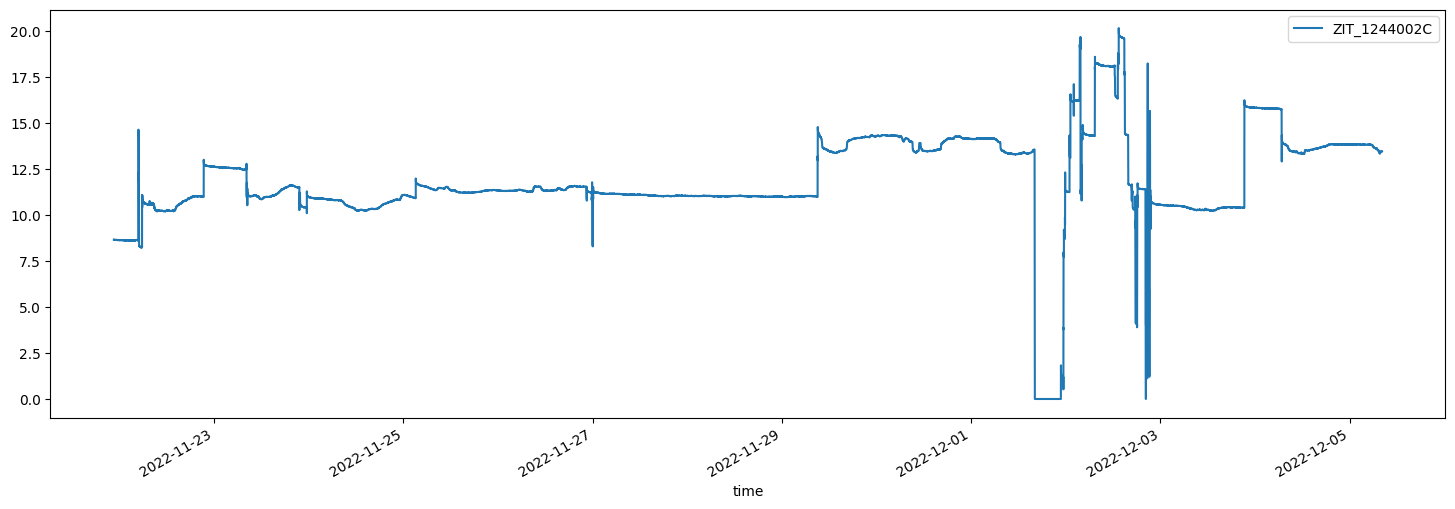

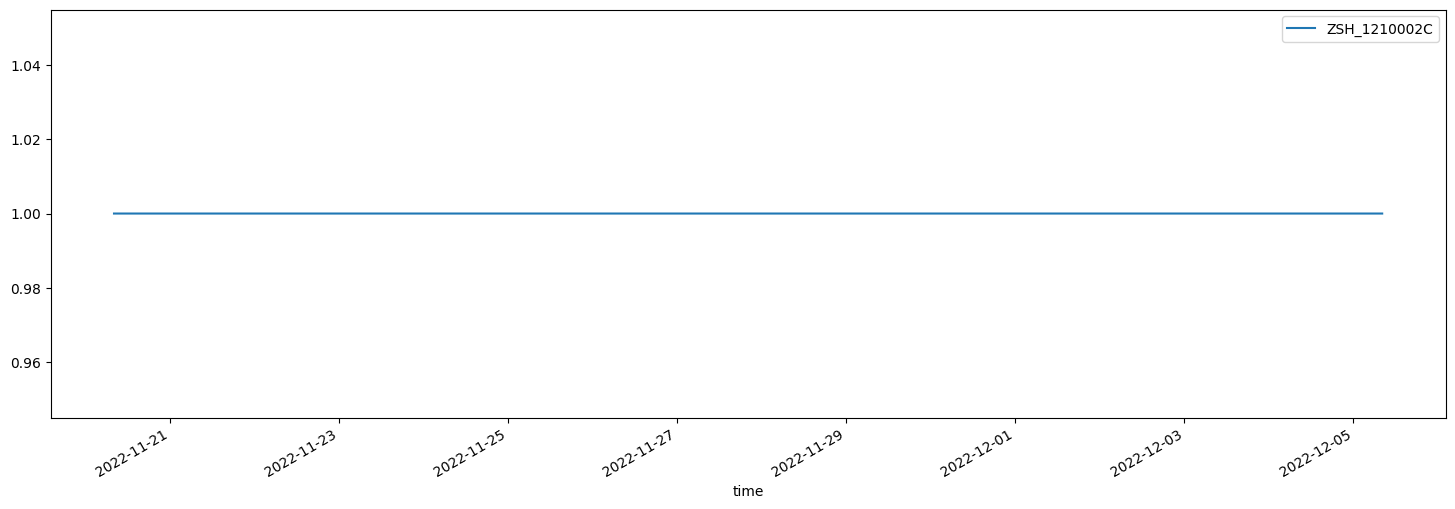

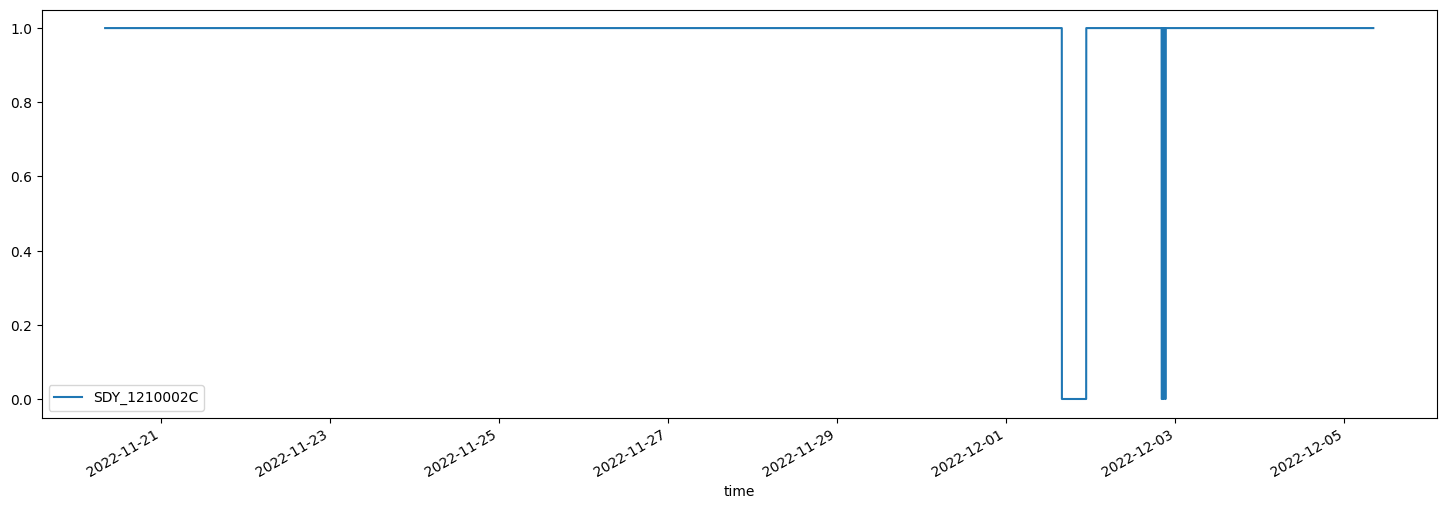

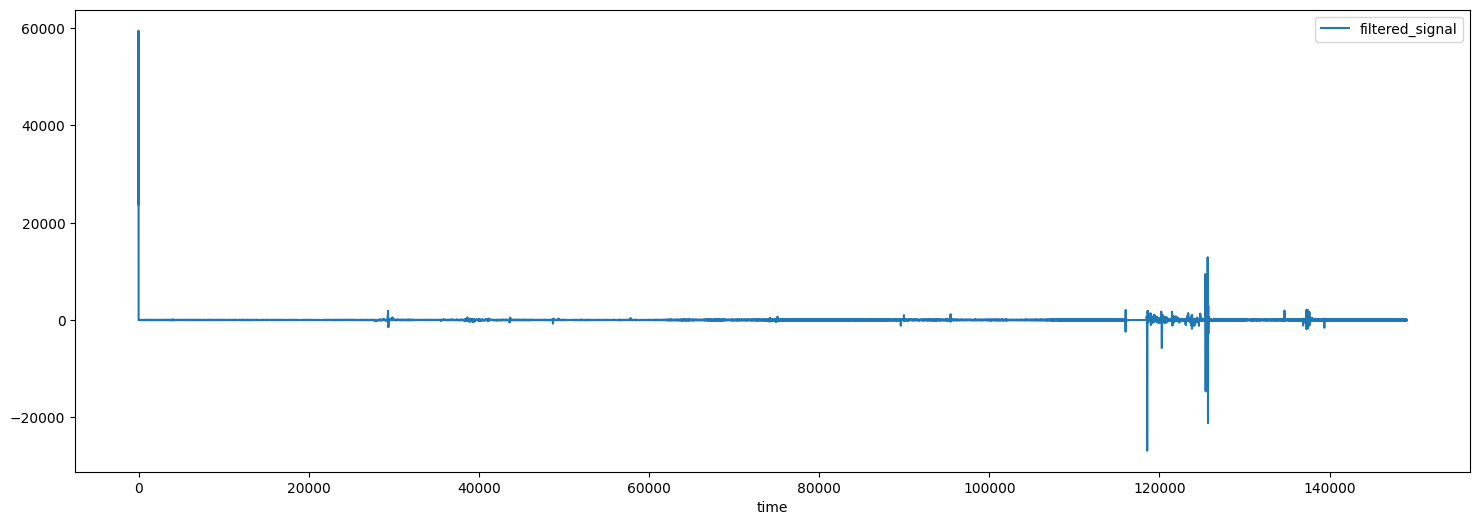

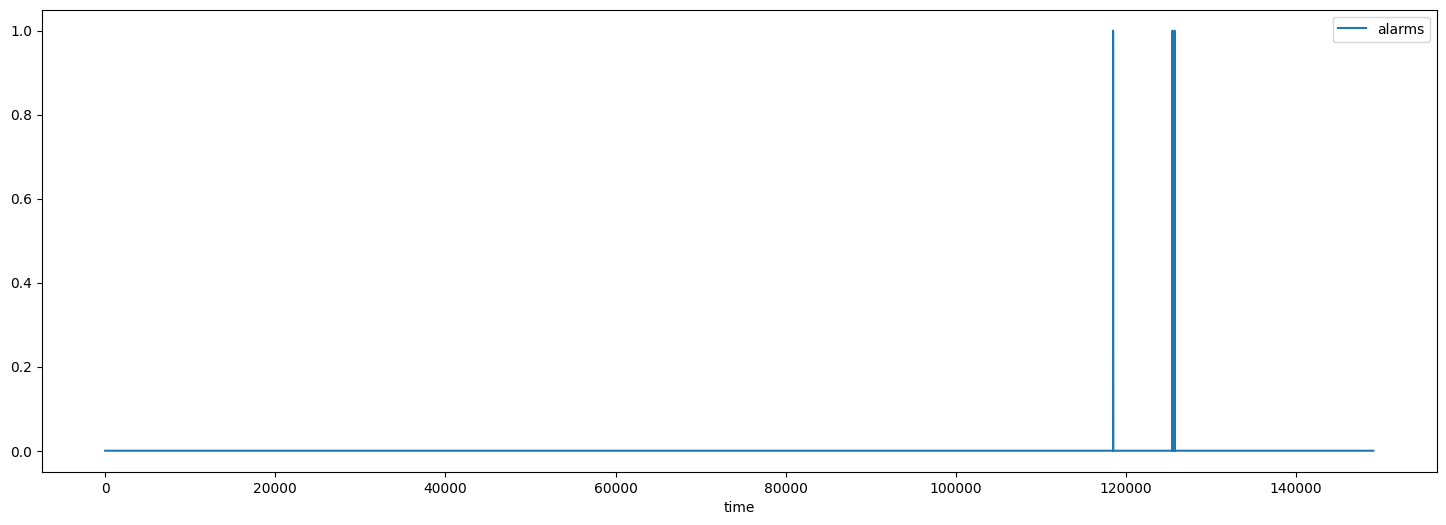

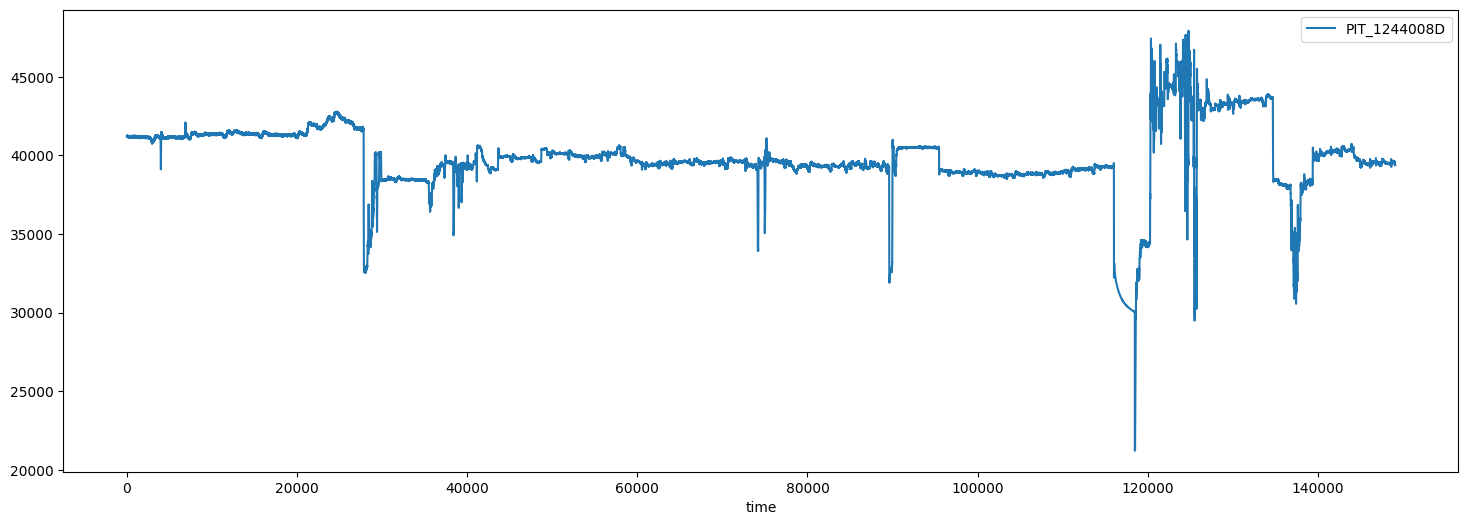

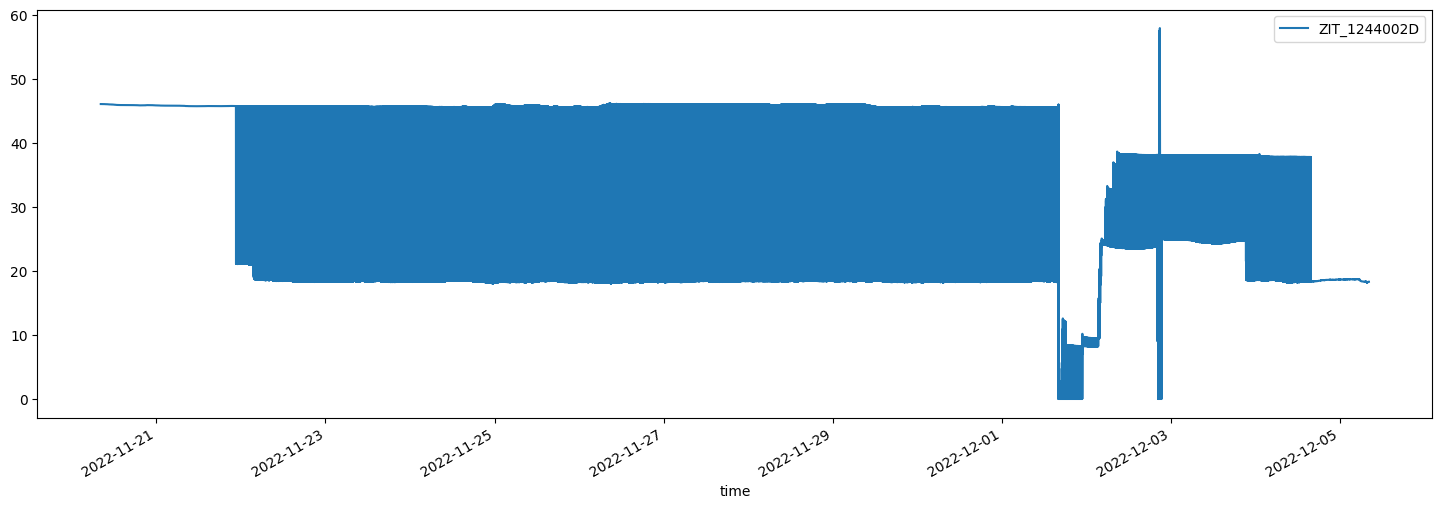

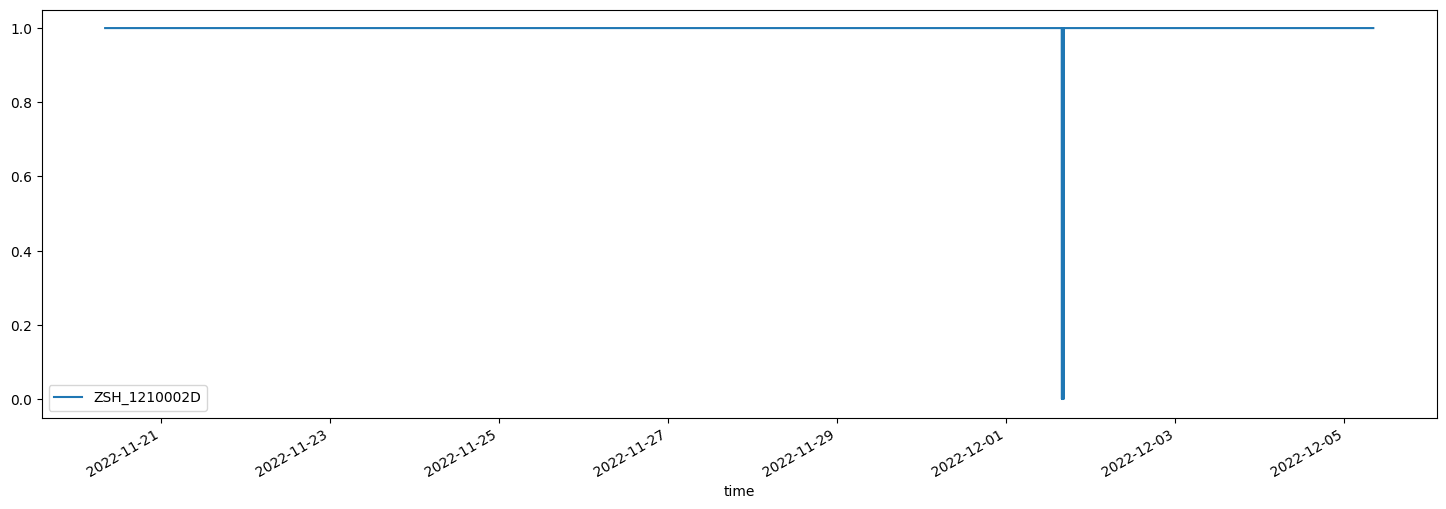

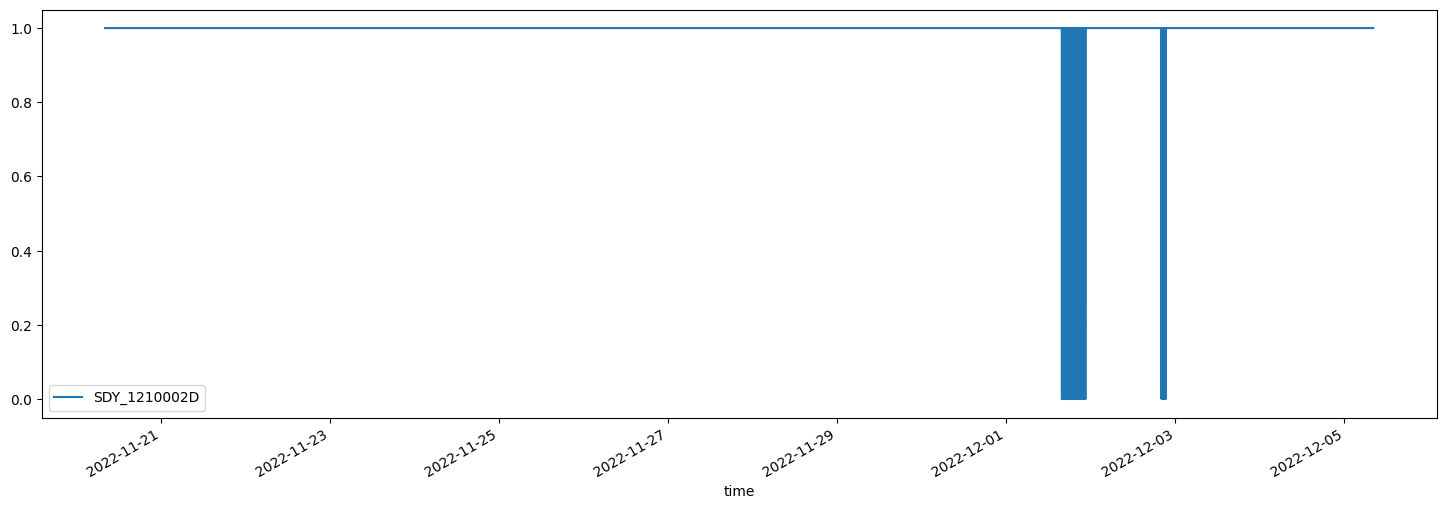

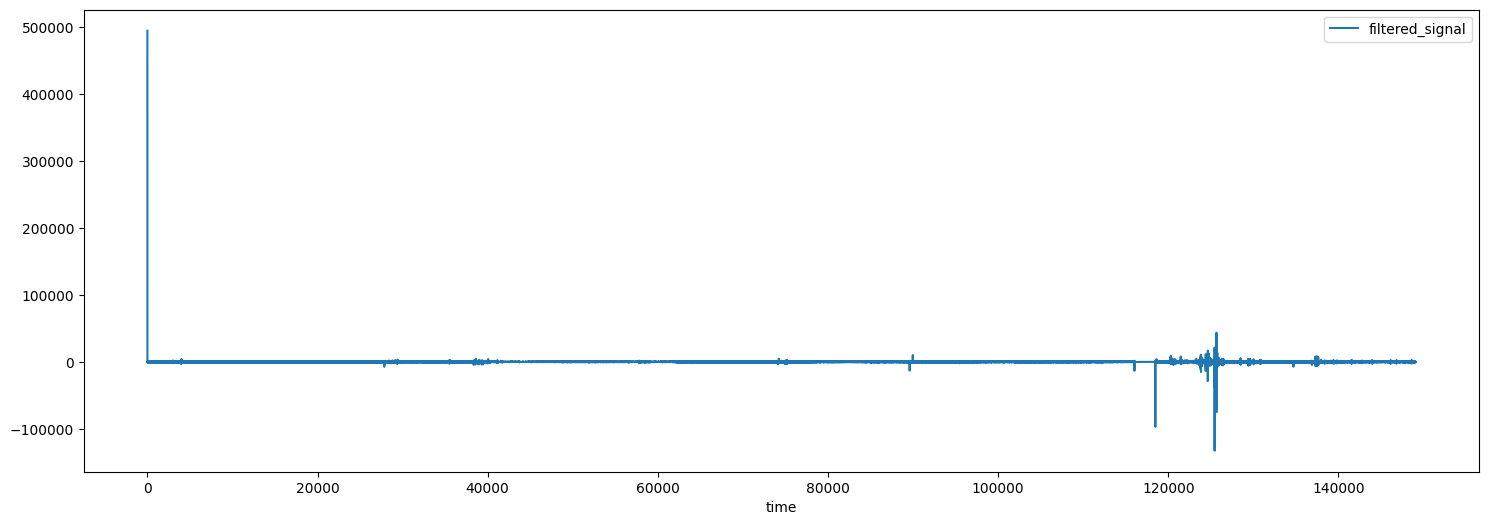

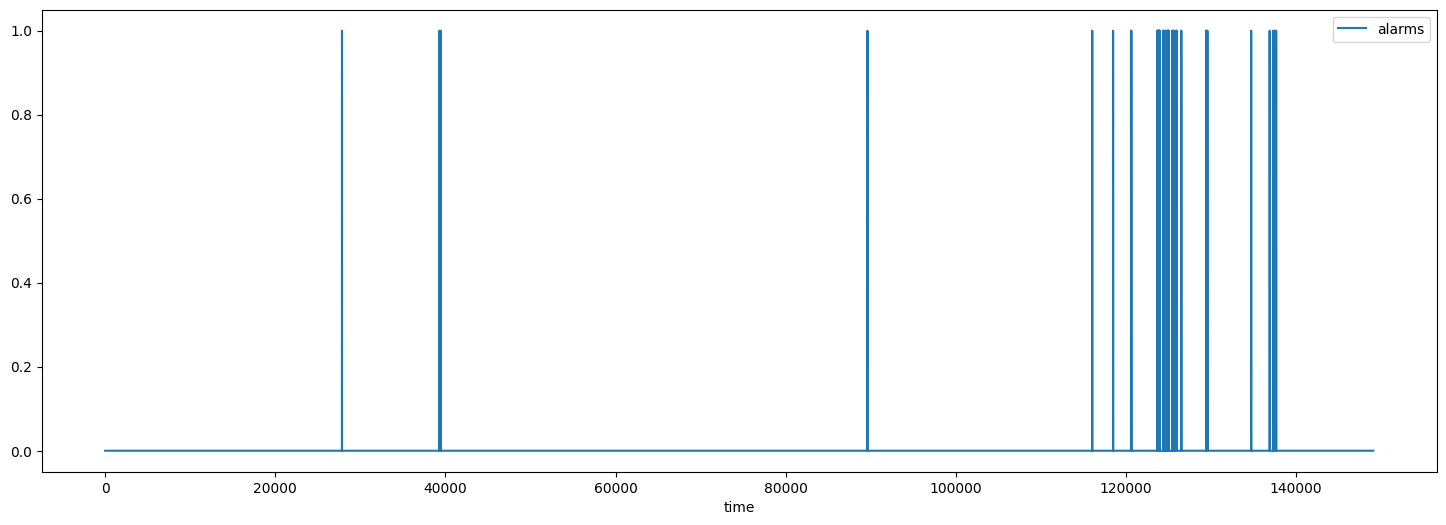

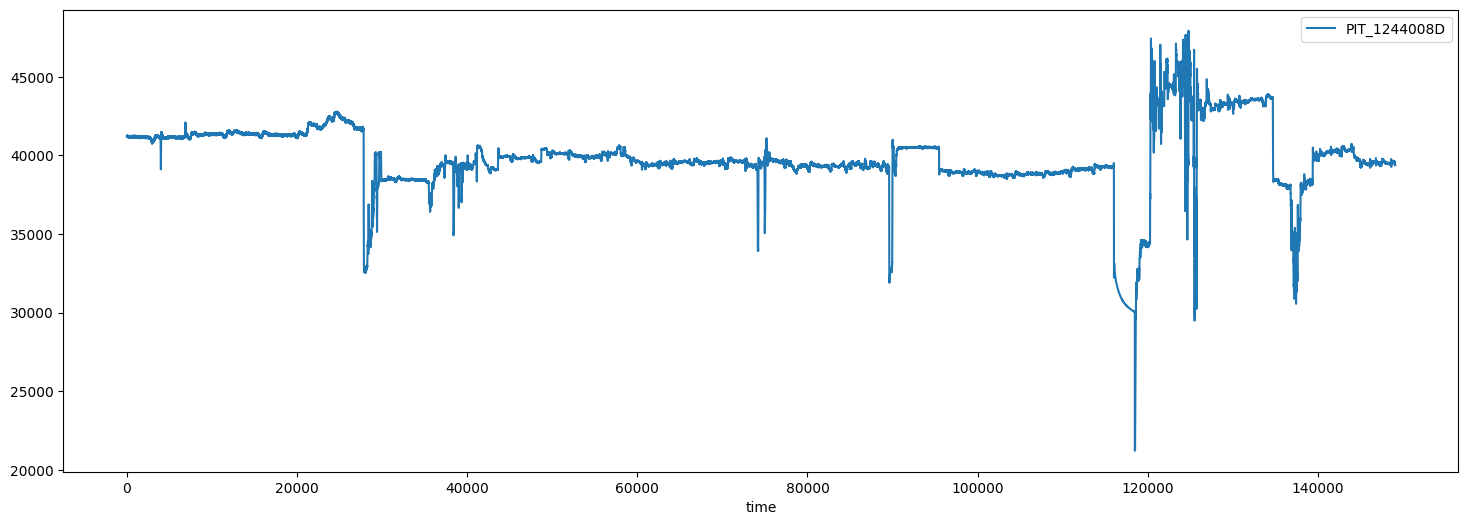

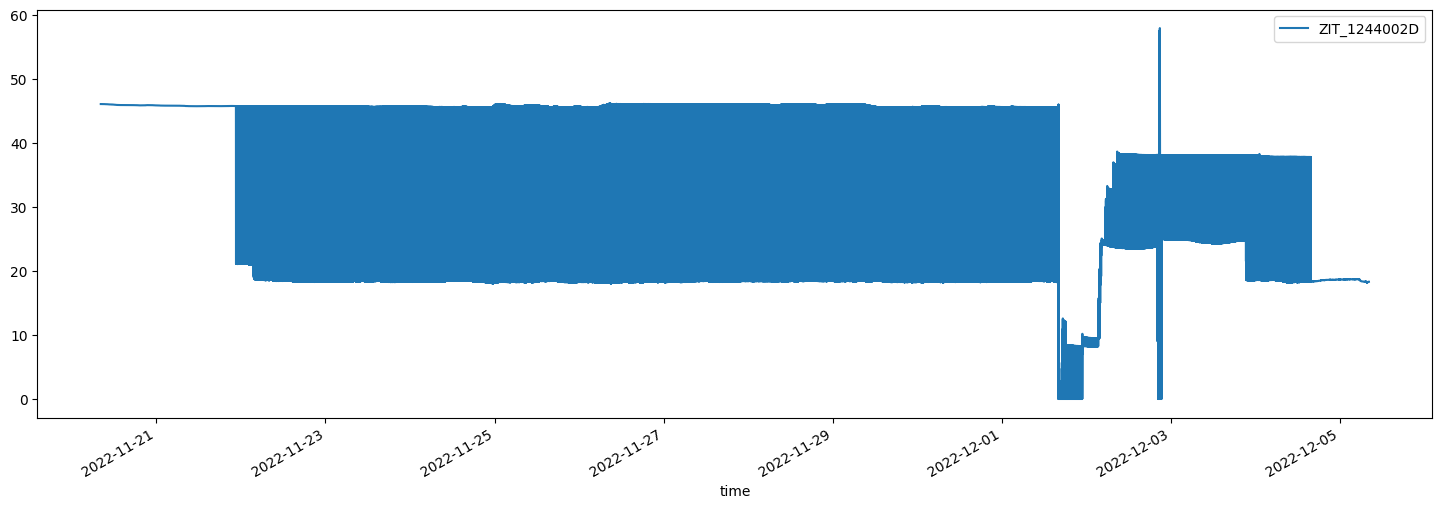

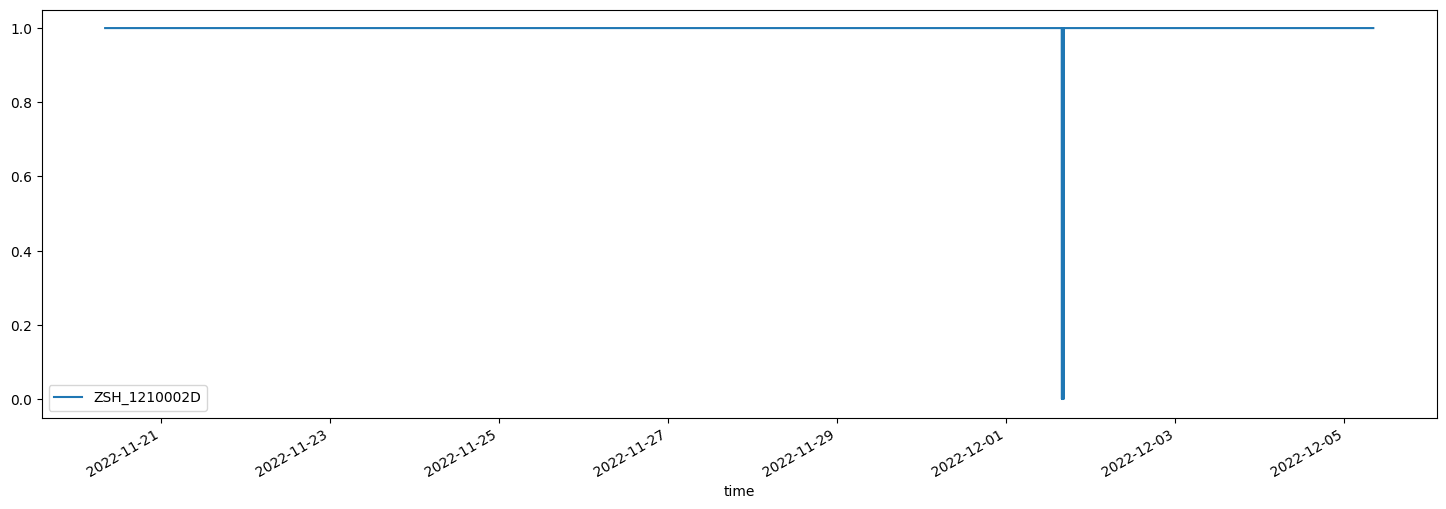

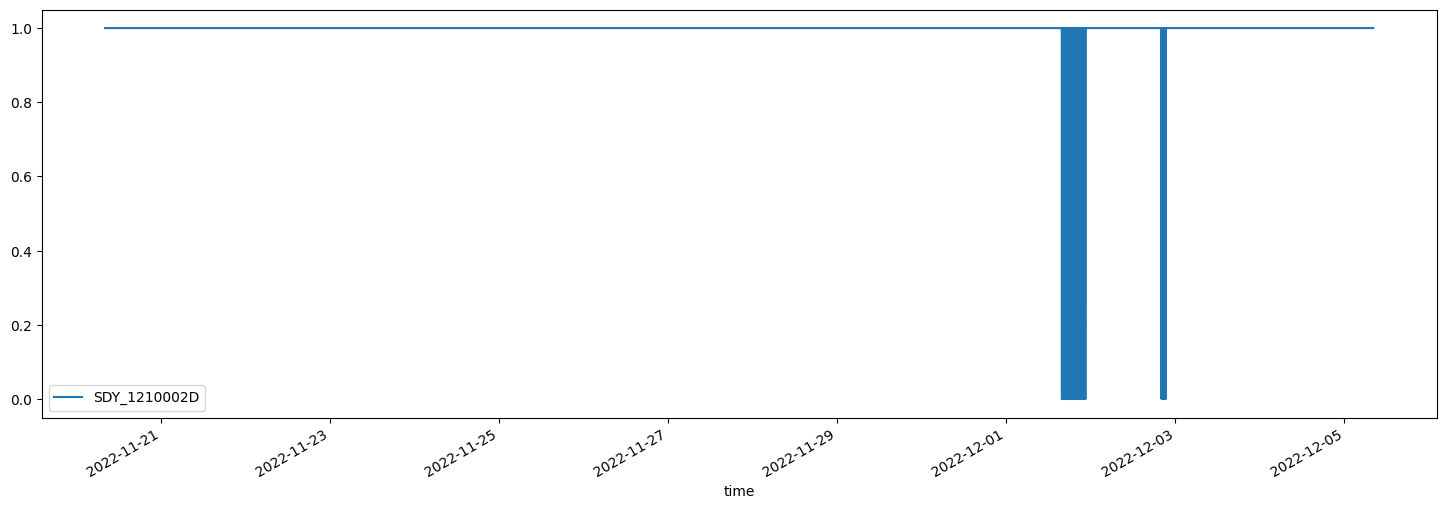

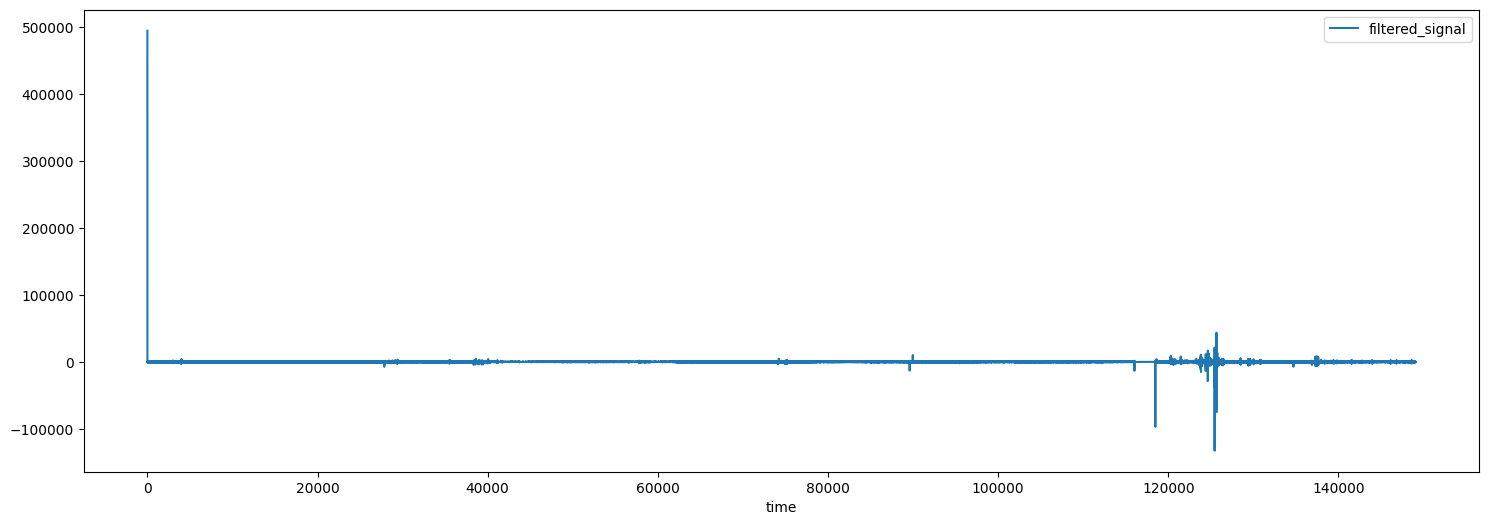

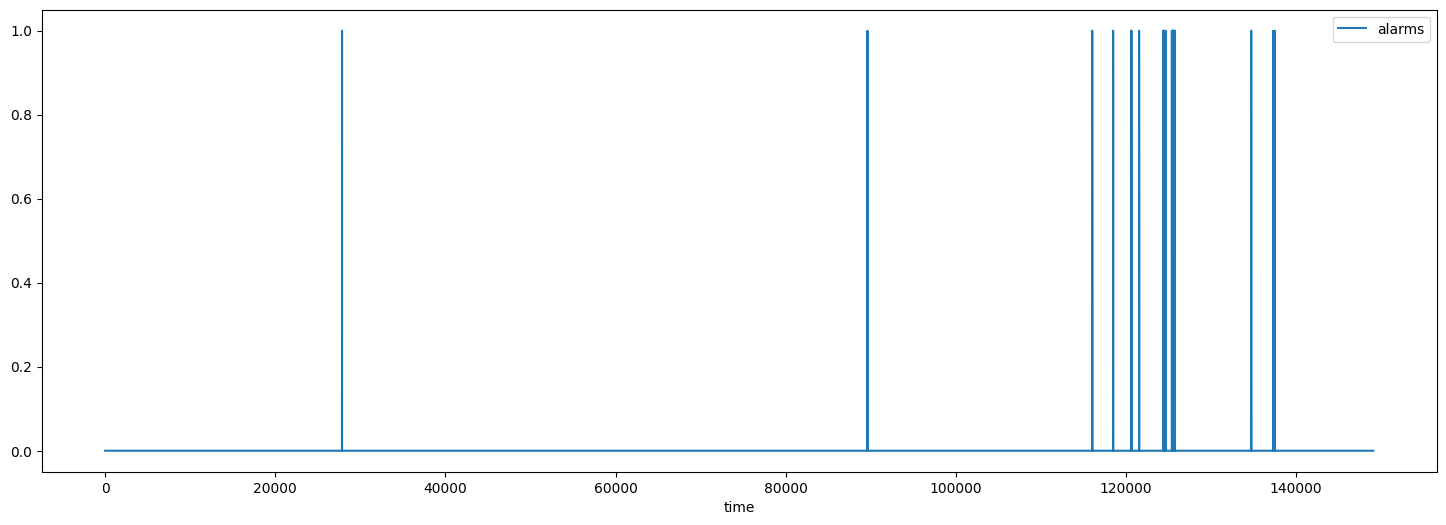

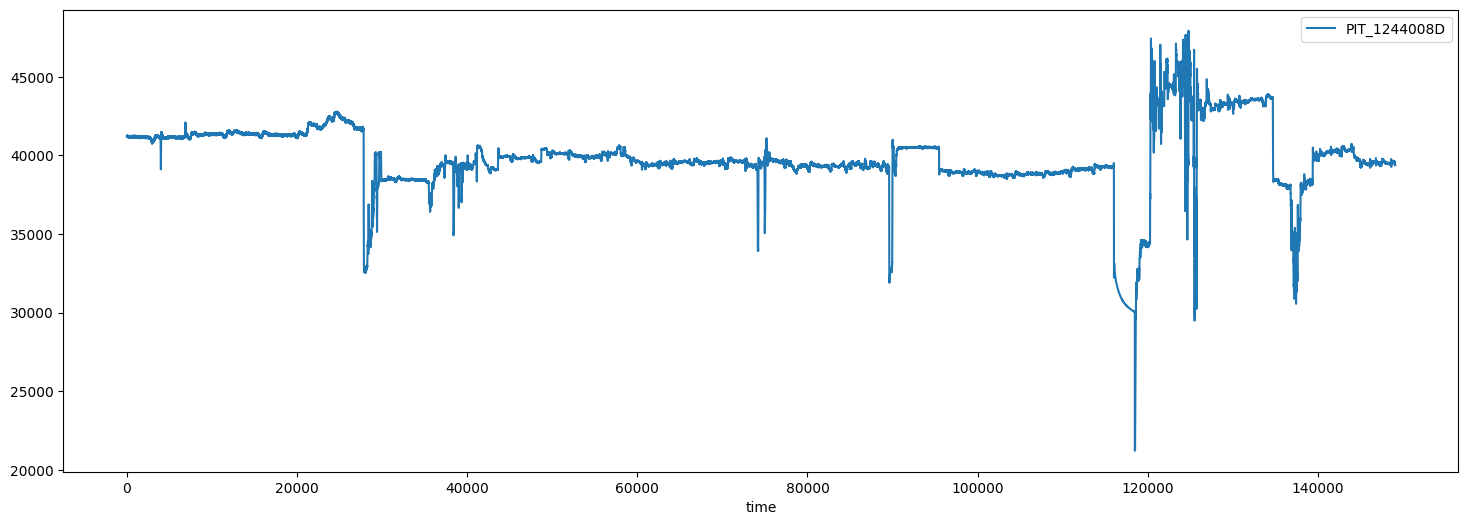

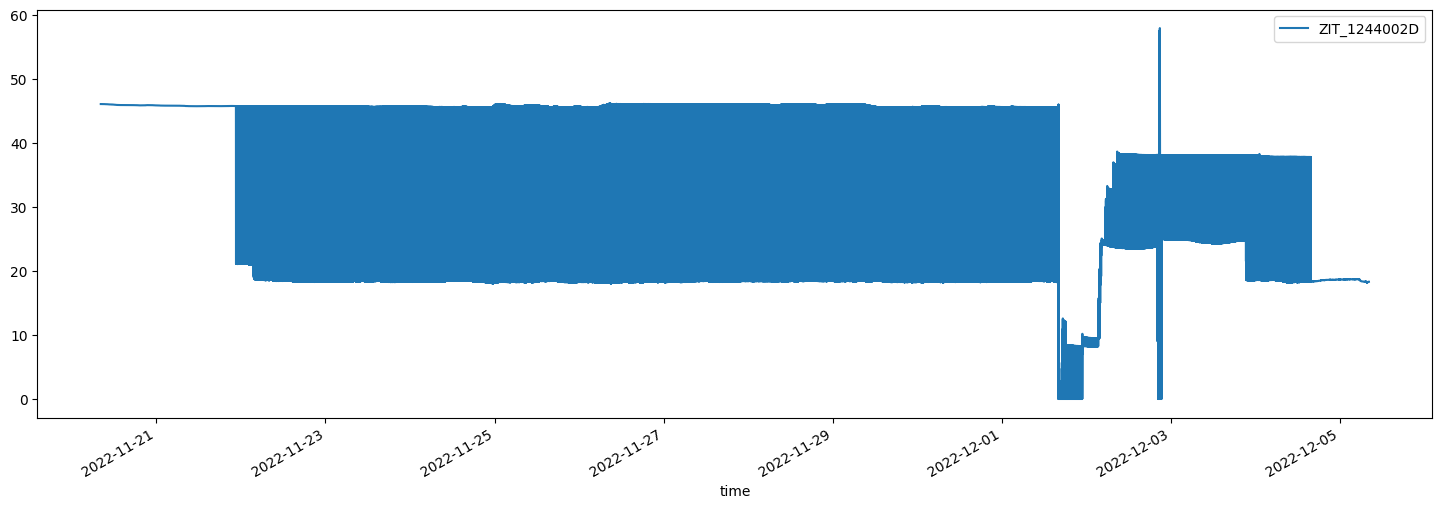

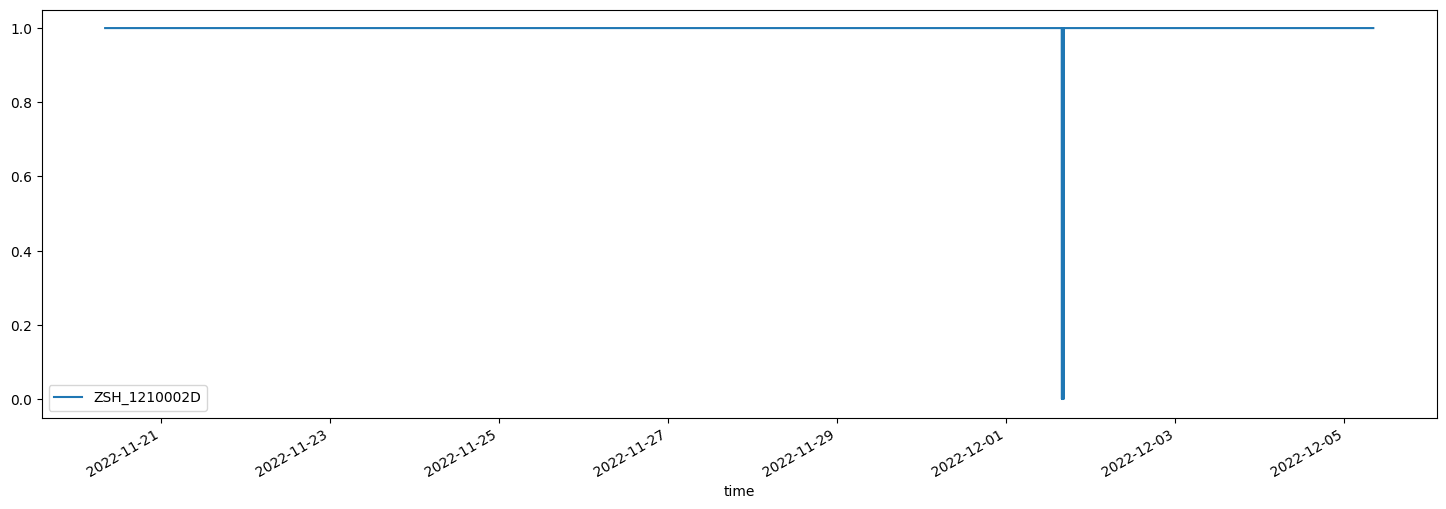

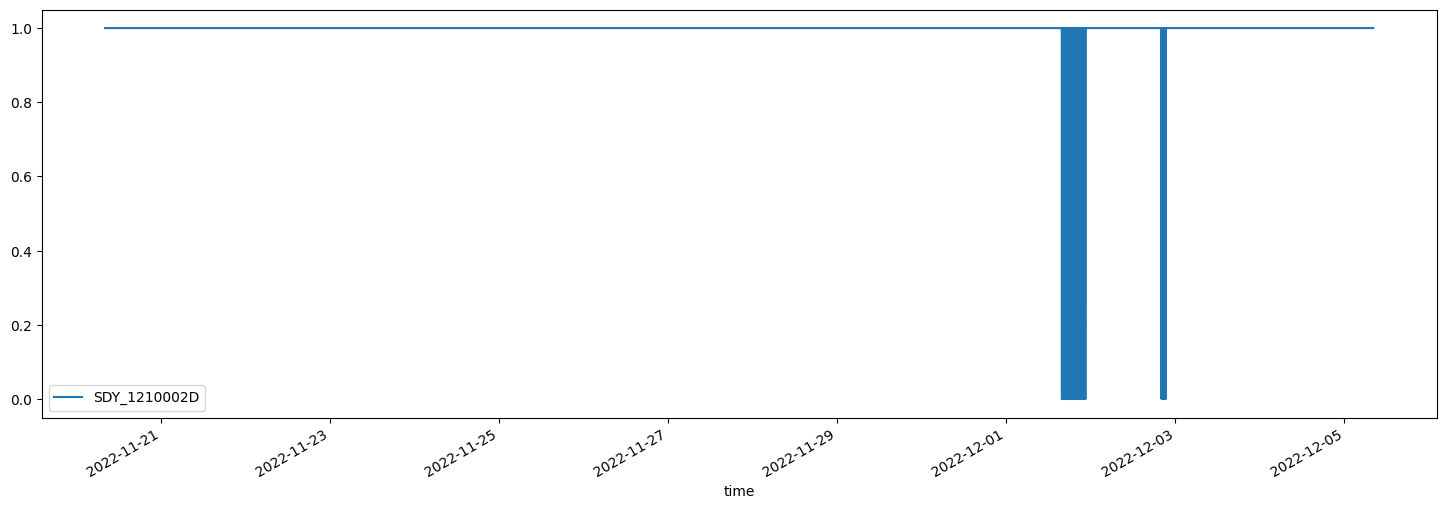

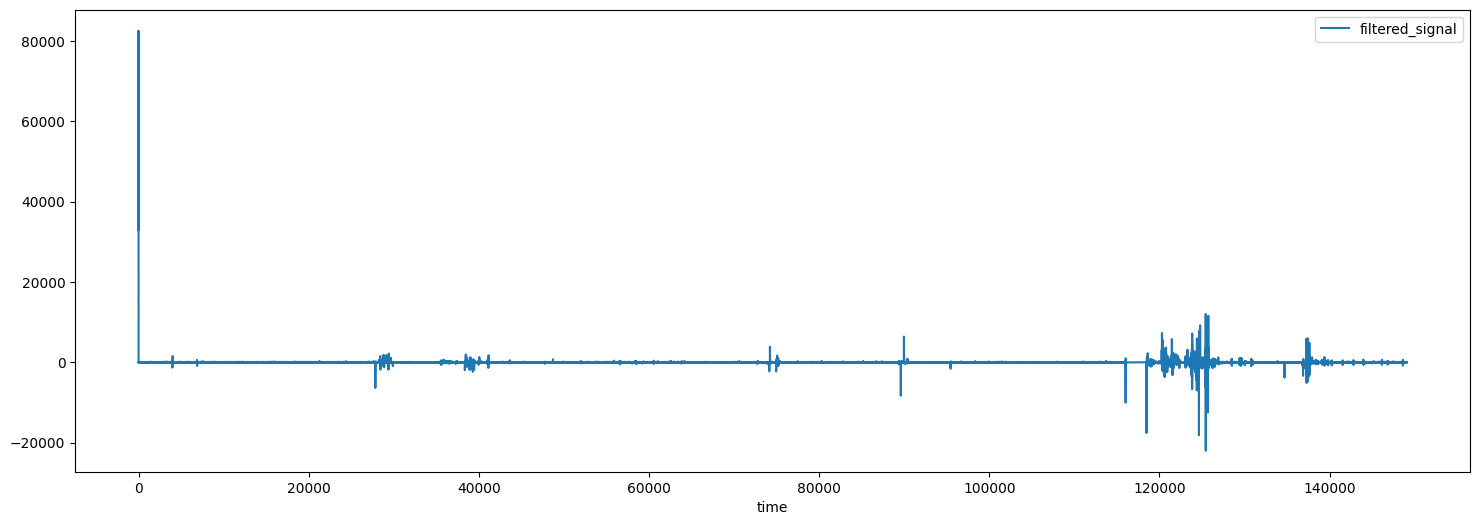

In [28]:
results = []
for p in pits:
    for well in set_points.keys():
        for set_point,gain,coef,temporiz, tp in zip(set_points[well],gains, coefs, temporizs, tps):
            print('Signal test for PKSLL_124400'+ p + well + tp)
            result = Signal().signalFilter(df = df,instrument = 'PIT_124400' + p + well, instrument_supress = ['ZIT_1244002' + well, 'ZSH_1210002' + well, 'SDY_1210002' + well], coef =  coef, gain = gain, set_point_ll = set_point, temporiz = temporiz)
            results.append(('PKSLL_124400' + p + well + tp, result))

In [29]:
print(results)

[('PKSLL_1244007C_TDP', 4), ('PKSLL_1244007C_SF', 2), ('PKSLL_1244007C_CF', 3), ('PKSLL_1244007D_TDP', 3), ('PKSLL_1244007D_SF', 85), ('PKSLL_1244007D_CF', 23), ('PKSLL_1244008C_TDP', 5), ('PKSLL_1244008C_SF', 2), ('PKSLL_1244008C_CF', 3), ('PKSLL_1244008D_TDP', 3), ('PKSLL_1244008D_SF', 87), ('PKSLL_1244008D_CF', 23)]


In [30]:
df_result = pd.DataFrame(data=results,columns=['Signal','Number of Spurius Alarms'])

In [40]:
display(df_result)

,Signal,Number of Spurius Alarms
0,PKSLL_1244007C_TDP,4
1,PKSLL_1244007C_SF,2
2,PKSLL_1244007C_CF,3
3,PKSLL_1244007D_TDP,3
4,PKSLL_1244007D_SF,85
5,PKSLL_1244007D_CF,23
6,PKSLL_1244008C_TDP,5
7,PKSLL_1244008C_SF,2
8,PKSLL_1244008C_CF,3
9,PKSLL_1244008D_TDP,3


In [32]:
from IPython.display import display

In [38]:
display(df_result.sum())

Signal                      PKSLL_1244007C_TDPPKSLL_1244007C_SFPKSLL_12440...
Number of Spurius Alarms                                                  243
dtype: object

|    Alarm Signal    | Number of Spurious Alarms |
|:------------------:|:-------------------------:|
| PKSLL_1244007C_TDP |             4             |
| PKSLL_1244007C_SF  |             2             |
| PKSLL_1244007C_CF  |             3             |
| PKSLL_1244007D_TDP |             3             |
| PKSLL_1244007D_SF  |             85            |
| PKSLL_1244007D_CF  |             23            |
| PKSLL_1244008C_TDP |             5             |
| PKSLL_1244008C_SF  |             2             |
| PKSLL_1244008C_CF  |             3             |
| PKSLL_1244008D_TDP |             3             |
| PKSLL_1244008D_SF  |             87            |
| PKSLL_1244008D_CF  |             23            |